In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from astroquery.sdss import SDSS

import sys, os
src_path = os.path.abspath(os.path.join("..", "src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)
from utils import astro_utils as au

In [2]:
print("Querying the SDSS DR12 database...")

query = """
SELECT
    s.specObjID,
    s.z,
    p.petroMag_r,
    p.objID,
    g.sfr_tot_p50 ,	g.specsfr_tot_p50, g.lgm_tot_p50,
    l.h_alpha_eqw, l.h_beta_eqw, l.oiii_5007_eqw, l.nii_6584_eqw,
    l.h_alpha_flux, l.h_beta_flux, l.oiii_5007_flux, l.nii_6584_flux
FROM SpecObj AS s
JOIN PhotoObj AS p ON s.bestObjID = p.objID
JOIN galSpecExtra as g ON s.specObjID = g.specObjID
JOIN galSpecLine as l ON s.specObjID = l.specObjID
WHERE s.z BETWEEN 0.005 AND 0.0452
  AND (p.petroMag_r - p.extinction_r <= 17.77)
  AND s.class = 'GALAXY'
"""
    

# Specify the data release (using DR12 as an example)
data_release = 12

# Execute the query via astroquery
result = SDSS.query_sql(query, data_release=data_release)
if result is None or len(result) == 0:
    raise RuntimeError("No data retrieved. Check your query and data release.")

# Convert the result to a Pandas DataFrame
df = result.to_pandas()

print(f"{len(df)} galaxies retrieved.")
print("Columns:", df.columns)
print("NB: physical parameters come from MPA-JHU spectroscopic catalogue")

Querying the SDSS DR12 database...
79067 galaxies retrieved.
Columns: Index(['specObjID', 'z', 'petroMag_r', 'objID', 'sfr_tot_p50',
       'specsfr_tot_p50', 'lgm_tot_p50', 'h_alpha_eqw', 'h_beta_eqw',
       'oiii_5007_eqw', 'nii_6584_eqw', 'h_alpha_flux', 'h_beta_flux',
       'oiii_5007_flux', 'nii_6584_flux'],
      dtype='object')
NB: physical parameters come from MPA-JHU spectroscopic catalogue


In [3]:
df['SFRcategory'] = au.my_SFRcategory(df)

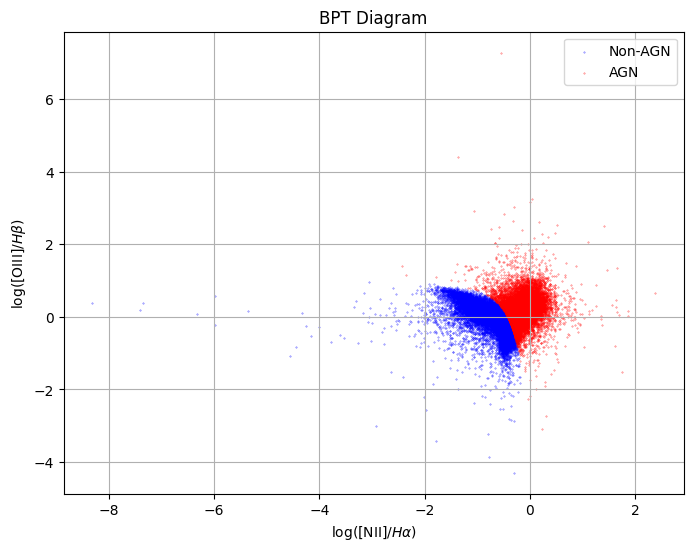

In [4]:
# Compute emission-line ratios for the BPT diagram.
def safe_log_ratio(numerator, denominator):
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where((denominator > 0) & (numerator > 0),
                        np.log10(numerator / denominator),
                        np.nan)

df['log_NII_Ha'] = safe_log_ratio(df['nii_6584_flux'], df['h_alpha_flux'])
df['log_OIII_Hb'] = safe_log_ratio(df['oiii_5007_flux'], df['h_beta_flux'])



# Classify galaxies as AGN using the Kewley et al. (2001) demarcation:
def classify_agn(row):
    if np.isnan(row['log_NII_Ha']) or np.isnan(row['log_OIII_Hb']):
        return False
    try:
        if row['log_NII_Ha'] > 0:
            return True
        elif (row['log_NII_Ha'] - 0.47) == 0:
            return False
        # return row['log_OIII_Hb'] > (0.61 / (row['log_NII_Ha'] - 0.47) + 1.19)
        return row['log_OIII_Hb'] > (0.61 / (row['log_NII_Ha'] - 0.05) + 1.3)
    except Exception:
        return False

df['is_AGN'] = df.apply(classify_agn, axis=1)

# Plot the BPT diagram with different colors for AGN and non-AGN.
plt.figure(figsize=(8, 6))
mask = df['log_NII_Ha'].notnull() & df['log_OIII_Hb'].notnull()
df_plot = df[mask]

agn = df_plot[df_plot['is_AGN']]
non_agn = df_plot[~df_plot['is_AGN']]

plt.scatter(non_agn['log_NII_Ha'], non_agn['log_OIII_Hb'], color='blue', label='Non-AGN', alpha=0.7, s=0.1)
plt.scatter(agn['log_NII_Ha'], agn['log_OIII_Hb'], color='red', label='AGN', alpha=0.7, s=0.1)

plt.xlabel(r'$\log([\mathrm{NII}]/H\alpha)$')
plt.ylabel(r'$\log([\mathrm{OIII}]/H\beta)$')
plt.title('BPT Diagram')
plt.legend()
plt.grid(True)
plt.show()

# Display the first few rows of the DataFrame.
# print("Data sample:")
# print(df.head())

In [5]:

# Cleaning the data
non_agn = df[~df['is_AGN']]
non_agn = non_agn.dropna(subset=['specsfr_tot_p50', 'lgm_tot_p50'])
non_agn = non_agn[non_agn['specsfr_tot_p50'] > -1000]
non_agn = non_agn[non_agn['lgm_tot_p50'] > 0]



In [6]:
print("Importing HMCG gals")

DATA_FOLDER = "../data/"

HMCG_gals = pd.read_csv(DATA_FOLDER+"EugeTableD2.dat",
                           header=None,
                           sep=r"\s+",
                           names=["Group","Id","RA","Dec",
                                  "z","R","G","objid"])

HMCG_gals = HMCG_gals.sort_values(by=['Group', 'Id'])

print("%i galaxies read, z between %f and %f, mag_r between %f and %f"%
      (HMCG_gals.shape[0],HMCG_gals['z'].min(),
       HMCG_gals['z'].max(),HMCG_gals['R'].min(),
       HMCG_gals['R'].max())
     )

Importing HMCG gals
2070 galaxies read, z between 0.002870 and 0.122845, mag_r between 10.587000 and 17.691000


In [7]:
HMCG_gals = HMCG_gals[HMCG_gals['z'] > 0.005]
HMCG_gals = HMCG_gals[HMCG_gals['z'] < 0.0452]
HMCG_gals = HMCG_gals[HMCG_gals['R'] < 17.77]

In [8]:
len(HMCG_gals)

1247

In [9]:
HMCG_sfr = non_agn.loc[non_agn['objID'].isin(HMCG_gals['objid'])]

In [10]:
len(HMCG_sfr)

878

In [11]:
non_agn['sSFR_excess'] = au.my_SFRexcess(non_agn['specsfr_tot_p50'],non_agn['lgm_tot_p50'])

Component 1: weight=0.174, mean=-0.421, std=0.421
Component 2: weight=0.826, mean=0.918, std=0.313

Minimum of the fitted mixture:
x = 0.0700
pdf = 1.1040e-01


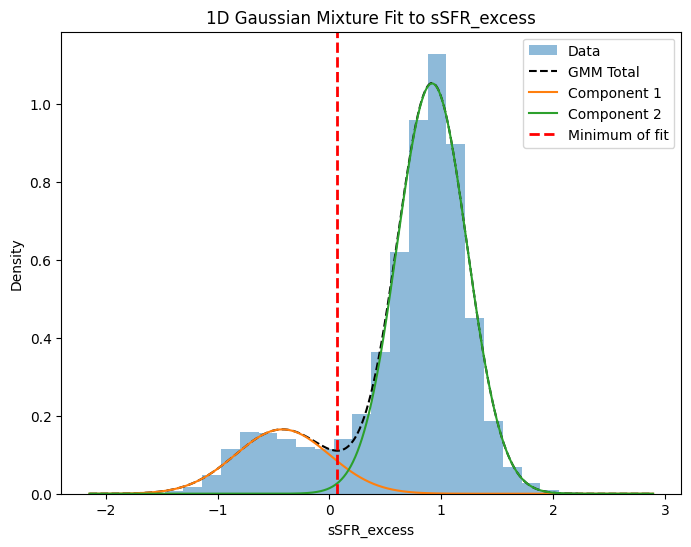

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.optimize import minimize_scalar

# Load your dataset (assuming 'non_agn.csv' with a column 'sSFR_excess')
df = non_agn
data = df['sSFR_excess'].dropna().values.reshape(-1, 1)

# Fit a 1D Gaussian Mixture with 2 components
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(data)

# Extract fitted parameters
weights = gmm.weights_
means = gmm.means_.flatten()
variances = gmm.covariances_.flatten()  # 1D variances
stds = np.sqrt(variances)

# Order the components by increasing mean
order = np.argsort(means)
w1, w2 = weights[order[0]], weights[order[1]]
mu1, mu2 = means[order[0]], means[order[1]]
std1, std2 = stds[order[0]], stds[order[1]]

print("Component 1: weight={:.3f}, mean={:.3f}, std={:.3f}".format(w1, mu1, std1))
print("Component 2: weight={:.3f}, mean={:.3f}, std={:.3f}".format(w2, mu2, std2))

# Define the overall pdf of the two components
def mixture_pdf(x):
    return w1 * norm.pdf(x, mu1, std1) + w2 * norm.pdf(x, mu2, std2)

# Find the minimum between the two means
res = minimize_scalar(mixture_pdf, bounds=(mu1, mu2), method='bounded')
min_x = res.x
min_pdf = res.fun

print("\nMinimum of the fitted mixture:")
print("x = {:.4f}".format(min_x))
print("pdf = {:.4e}".format(min_pdf))

# Visualization
plt.figure(figsize=(8,6))
# Plot histogram of sSFR_excess
counts, bins, _ = plt.hist(data, bins=30, density=True, alpha=0.5, label='Data')

# Create x values for plotting the mixture pdf
x_vals = np.linspace(data.min(), data.max(), 1000)
pdf_vals = mixture_pdf(x_vals)
plt.plot(x_vals, pdf_vals, 'k--', label='GMM Total')

# Plot individual Gaussian components
plt.plot(x_vals, w1 * norm.pdf(x_vals, mu1, std1), label='Component 1')
plt.plot(x_vals, w2 * norm.pdf(x_vals, mu2, std2), label='Component 2')

# Mark the minimum
plt.axvline(min_x, color='red', linestyle='--', linewidth=2, label='Minimum of fit')
plt.xlabel('sSFR_excess')
plt.ylabel('Density')
plt.title('1D Gaussian Mixture Fit to sSFR_excess')
plt.legend()
plt.show()

In [28]:
# Classify galaxies as star-forming (F) or quiescent (Q) based on the minimum
# of the fitted Gaussian mixture.
conditions = [
        (non_agn['sSFR_excess'] > min_x),
        (non_agn['sSFR_excess'] <= min_x)]
choices = ['F', 'Q']

non_agn['SFRcategory'] = np.select(conditions, choices, default='X')

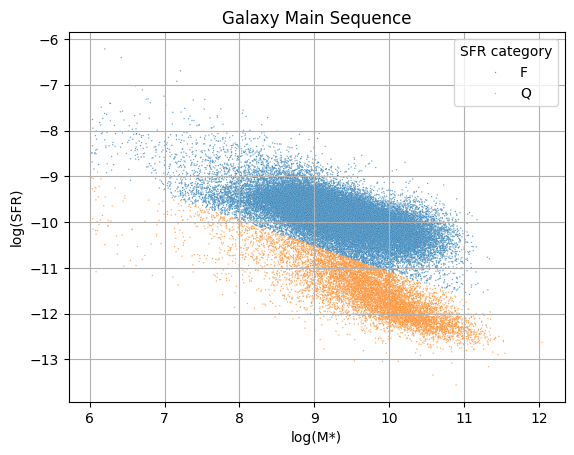

In [29]:
sns.scatterplot(data=non_agn, x='lgm_tot_p50', y='specsfr_tot_p50', hue='SFRcategory', alpha=0.7, s=1)
plt.xlabel('log(M*)')
plt.ylabel('log(SFR)')
plt.title('Galaxy Main Sequence')
plt.legend(title='SFR category')
plt.grid(True)
plt.show()


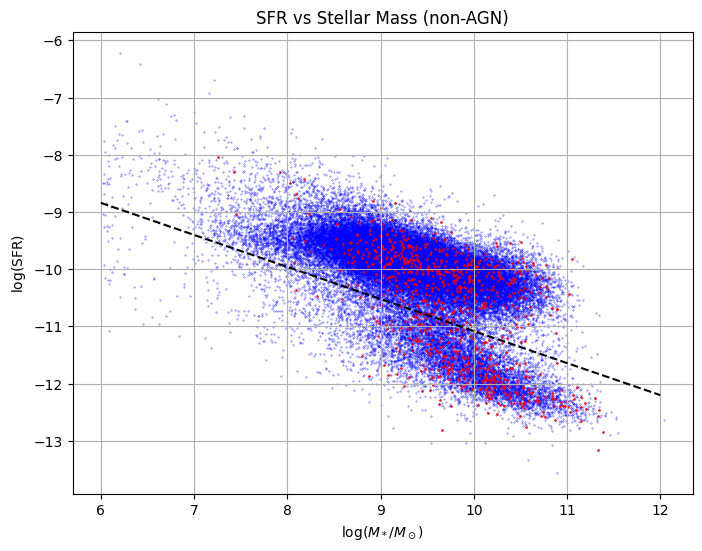

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(non_agn['lgm_tot_p50'], non_agn['specsfr_tot_p50'], color='blue', alpha=0.7, s=0.1)
plt.scatter(HMCG_sfr['lgm_tot_p50'], HMCG_sfr['specsfr_tot_p50'], color='red', alpha=0.7, s=1)

# Add a line having for equation y = a x + b
x = np.linspace(6, 12, 100)
y = au.my_sSFRline(x) + min_x
plt.plot(x, y, color='black', linestyle='--', label=f'Separation line')

plt.xlabel(r'$\log(M_*/M_\odot)$')
plt.ylabel(r'$\log(\mathrm{SFR})$')
plt.title('SFR vs Stellar Mass (non-AGN)')
plt.grid(True)
plt.show()

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from astroquery.sdss import SDSS

#* --------------------------------------------------------------------------------
#* Querying the SDSS DR12 database to retrieve galaxy information.
#* We use astroquery.sdss to send SQL queries directly to the SDSS database.
#* --------------------------------------------------------------------------------

print("Querying the SDSS DR12 database...")

query = """
SELECT
    s.specObjID,
    s.z,
    p.petroMag_r,
    p.objID,
    g.sfr_tot_p50 , g.specsfr_tot_p50, g.lgm_tot_p50,
    l.h_alpha_eqw, l.h_beta_eqw, l.oiii_5007_eqw, l.nii_6584_eqw,
    l.h_alpha_flux, l.h_beta_flux, l.oiii_5007_flux, l.nii_6584_flux
FROM SpecObj AS s
JOIN PhotoObj AS p ON s.bestObjID = p.objID
JOIN galSpecExtra as g ON s.specObjID = g.specObjID
JOIN galSpecLine as l ON s.specObjID = l.specObjID
WHERE s.z BETWEEN 0.005 AND 0.0452
  AND (p.petroMag_r - p.extinction_r <= 17.77)
  AND s.class = 'GALAXY'
"""

#* Specify the data release (using DR12 as an example)
data_release = 12

#* Execute the query via astroquery
result = SDSS.query_sql(query, data_release=data_release)
if result is None or len(result) == 0:
    raise RuntimeError("No data retrieved. Check your query and data release.")

#* Convert the result to a Pandas DataFrame
df = result.to_pandas()

print(f"{len(df)} galaxies retrieved.")
print("NB: physical parameters come from MPA-JHU spectroscopic catalogue")

#* --------------------------------------------------------------------------------
#* Compute emission line ratios for BPT diagnostic diagrams.
#* safe_log_ratio() avoids invalid operations.
#* --------------------------------------------------------------------------------
def safe_log_ratio(numerator, denominator):
    """Compute log10(numerator/denominator) safely, returning NaN when invalid."""
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where(
            (denominator > 0) & (numerator > 0),
            np.log10(numerator / denominator),
            np.nan
        )

df['log_NII_Ha'] = safe_log_ratio(df['nii_6584_flux'], df['h_alpha_flux'])
df['log_OIII_Hb'] = safe_log_ratio(df['oiii_5007_flux'], df['h_beta_flux'])

#* --------------------------------------------------------------------------------
#* Classify galaxies as AGN using a basic cut approximating Kewley et al. criteria.
#* --------------------------------------------------------------------------------
def classify_agn(row):
    """Returns True if the galaxy is classified as AGN based on NII/Ha & OIII/Hb."""
    if np.isnan(row['log_NII_Ha']) or np.isnan(row['log_OIII_Hb']):
        return False
    try:
        if row['log_NII_Ha'] > 0:
            return True
        elif (row['log_NII_Ha'] - 0.47) == 0:
            return False
        return row['log_OIII_Hb'] > (0.61 / (row['log_NII_Ha'] - 0.05) + 1.3)
    except Exception:
        return False

df['is_AGN'] = df.apply(classify_agn, axis=1)

#* --------------------------------------------------------------------------------
#* Basic BPT diagram data separation
#* --------------------------------------------------------------------------------
mask = df['log_NII_Ha'].notnull() & df['log_OIII_Hb'].notnull()
df_plot = df[mask]

agn = df_plot[df_plot['is_AGN']]
non_agn = df_plot[~df_plot['is_AGN']]

#* --------------------------------------------------------------------------------
#* Cleaning the data to exclude AGN and invalid M* or sSFR.
#* --------------------------------------------------------------------------------
non_agn = df[~df['is_AGN']]  #* Only non-AGN galaxies
non_agn = non_agn.dropna(subset=['specsfr_tot_p50', 'lgm_tot_p50'])
non_agn = non_agn[non_agn['specsfr_tot_p50'] > -1000]
non_agn = non_agn[non_agn['lgm_tot_p50'] > 0]

#* --------------------------------------------------------------------------------
#* Convert data to NumPy arrays (removed PyTorch usage).
#* Here we keep the raw and optionally normalized versions if needed.
#* --------------------------------------------------------------------------------
X = non_agn[['lgm_tot_p50', 'specsfr_tot_p50']].values

#* Example optional normalization using NumPy:
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_normalized = (X - X_mean) / (X_std + 1e-8)  #* Add small epsilon to avoid zero div

#* --------------------------------------------------------------------------------
#* Essential imports for GMM fitting with SciPy and for plotting
#* --------------------------------------------------------------------------------
import time
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

#* --------------------------------------------------------------------------------
#* Set random seed for reproducibility
#* --------------------------------------------------------------------------------
np.random.seed(42)

#* --------------------------------------------------------------------------------
#* Define GMM-related functions: gmm_pdf, estimate_kl_divergence, parameter conversions,
#* objective function, multi-initialization GMM fitting, and ellipse plotting.
#* --------------------------------------------------------------------------------

def gmm_pdf(X, means, covs, weights):
    """
    Compute the probability density function of a 2-component Gaussian Mixture Model (GMM) 
    at points X. Each GMM component has its own mean, covariance, and weight.
    """
    n_samples = X.shape[0]
    pdf_values = np.zeros(n_samples)
    for i in range(2):
        pdf_values += weights[i] * multivariate_normal.pdf(
            X, mean=means[i], cov=covs[i], allow_singular=True
        )
    return pdf_values

def estimate_kl_divergence(X, means, covs, weights, n_bins=50):
    """
    Estimate KL divergence between empirical data and a GMM using histogram approximation.
    We create a 2D histogram of the data, evaluate the GMM on the histogram grid, 
    and sum p_data * log(p_data / p_model).
    """
    #* Create 2D histogram
    hist, x_edges, y_edges = np.histogram2d(X[:, 0], X[:, 1], bins=n_bins, density=True)
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    X_grid, Y_grid = np.meshgrid(x_centers, y_centers)
    grid_points = np.column_stack([X_grid.flatten(), Y_grid.flatten()])
    
    gmm_values = gmm_pdf(grid_points, means, covs, weights).reshape(X_grid.shape)
    
    epsilon = 1e-10
    hist = hist + epsilon
    gmm_values = gmm_values + epsilon
    kl_div = np.sum(hist * np.log(hist / gmm_values.T))
    
    return kl_div

def params_to_gmm(params, constrain_means=False):
    """
    Convert a flat parameter vector into GMM parameters (means, covariances, weights). 
    Optionally constrain the second mean's y-coordinate to [-12, -10].
    """
    mean1 = params[0:2]
    mean2 = params[2:4]
    if constrain_means:
        mean2[1] = np.clip(mean2[1], -12.0, -10.0)
    
    #* Build covariance matrices from a Cholesky-like representation
    L1 = np.zeros((2, 2))
    L1[0, 0] = np.exp(params[4])
    L1[1, 0] = params[5]
    L1[1, 1] = np.exp(params[6])
    
    L2 = np.zeros((2, 2))
    L2[0, 0] = np.exp(params[7])
    L2[1, 0] = params[8]
    L2[1, 1] = np.exp(params[9])
    
    cov1 = L1 @ L1.T
    cov2 = L2 @ L2.T
    
    w = 1 / (1 + np.exp(-params[10]))  #* logistic function => weight in (0,1)
    
    return [mean1, mean2], [cov1, cov2], [w, 1 - w]

def objective(params, X, constrain_means=False, constrain_covs=False,
              mean_penalty=1000.0, cov_penalty=100.0):
    """
    Objective function for the optimizer. Minimizes KL divergence and adds additional 
    penalties for violating mean/covariance constraints if requested.
    """
    means, covs, weights = params_to_gmm(params, constrain_means)
    kl_div = estimate_kl_divergence(X, means, covs, weights)
    penalty = 0.0
    
    #* Mean constraint
    if constrain_means:
        y_coord = means[1][1]  #* second component's y-mean
        if y_coord > -10.0 + 0.3 or y_coord < -12.0 - 0.3:
            penalty += mean_penalty * min(abs(y_coord - (-10.0)), abs(y_coord - (-12.0)))
    
    #* Covariance constraint
    if constrain_covs:
        det1 = np.linalg.det(covs[0])
        det2 = np.linalg.det(covs[1])
        if det2 > det1:
            penalty += cov_penalty * (det2 - det1)
    
    return kl_div + penalty

def fit_gmm_to_data(X, constrain_means=False, constrain_covs=False, n_init=10):
    """
    Fit a 2-component GMM to data via KL divergence minimization.
    Multiple random initializations are tried for robustness, and the best solution is chosen.
    """
    best_result = None
    best_kl = float('inf')
    
    data_cov = np.cov(X.T)
    initializations = []
    
    #* Guided initialization based on median split of y-values
    mid_quantile = np.quantile(X[:, 1], 0.5)
    upper_mask = X[:, 1] > mid_quantile
    lower_mask = ~upper_mask
    
    if np.sum(upper_mask) > 0 and np.sum(lower_mask) > 0:
        mean1 = np.mean(X[upper_mask], axis=0)
        mean2 = np.mean(X[lower_mask], axis=0)
        if constrain_means:
            mean2[1] = np.clip(mean2[1], -12.0, -10.0)
        
        init_params = np.array([
            mean1[0], mean1[1], mean2[0], mean2[1],
            np.log(np.sqrt(data_cov[0, 0])), 0, np.log(np.sqrt(data_cov[1, 1])),
            np.log(np.sqrt(data_cov[0, 0] * 0.7)), 0, np.log(np.sqrt(data_cov[1, 1] * 0.7)),
            0  #* logit(0.5)
        ])
        initializations.append(init_params)
    
    #* Additional random initializations
    for i in range(n_init - len(initializations)):
        idx = np.random.choice(len(X), 2, replace=False)
        mean1 = X[idx[0]]
        mean2 = X[idx[1]]
        if constrain_means:
            mean2[1] = np.random.uniform(-12.0, -10.0)
        
        init_params = np.array([
            mean1[0], mean1[1], mean2[0], mean2[1],
            np.log(np.sqrt(data_cov[0, 0])), 0, np.log(np.sqrt(data_cov[1, 1])),
            np.log(np.sqrt(data_cov[0, 0] * 0.7)), 0, np.log(np.sqrt(data_cov[1, 1] * 0.7)),
            0
        ])
        initializations.append(init_params)
    
    #* Try each initialization
    for i, init_params in enumerate(initializations):
        print(f"Running initialization {i+1}/{len(initializations)}...")
        result = minimize(
            lambda p: objective(p, X, constrain_means, constrain_covs),
            init_params, method='L-BFGS-B', options={'maxiter': 3000, 'disp': False}
        )
        if not result.success:
            print("  Initial optimization failed, trying Nelder-Mead...")
            result = minimize(
                lambda p: objective(p, X, constrain_means, constrain_covs),
                result.x, method='Nelder-Mead', options={'maxiter': 5000, 'disp': False}
            )
        
        means, covs, weights = params_to_gmm(result.x, constrain_means)
        kl_div = estimate_kl_divergence(X, means, covs, weights)
        print(f"  Finished with KL divergence: {kl_div:.4f}")
        
        if kl_div < best_kl:
            best_kl = kl_div
            best_result = (means, covs, weights, kl_div)
            print("  New best result found!")
    
    return best_result

def plot_gaussian_contours(ax, mean, cov, color, alpha=0.3):
    """
    Draw an ellipse representing a specified covariance contour (3 sigma) 
    for clarity in GMM component distribution plots.
    """
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(vals) * 3
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta,
                      facecolor=color, alpha=alpha, edgecolor='black')
    ax.add_patch(ellipse)

def fit_and_visualize_gmm(original_data):
    """
    Fit a 2-component GMM to 'original_data' using constrained minimization of the KL divergence.
    Then visualize the resulting mixture with contours overlaid on the data.
    """
    print("Fitting GMM to original data...")
    start_time = time.time()
    means_orig, covs_orig, weights_orig, kl_div_orig = fit_gmm_to_data(
        original_data, constrain_means=True, constrain_covs=True, n_init=5
    )
    print(f"Fitting completed in {time.time() - start_time:.2f} seconds")
    print(f"Original data KL divergence: {kl_div_orig:.4f}")
    
    #* Prepare grid for GMM density
    x_min, x_max = original_data[:, 0].min() - 0.5, original_data[:, 0].max() + 0.5
    y_min, y_max = original_data[:, 1].min() - 0.5, original_data[:, 1].max() + 0.5
    x_grid, y_grid = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )
    grid_points = np.column_stack([x_grid.flatten(), y_grid.flatten()])
    gmm_density_orig = gmm_pdf(grid_points, means_orig, covs_orig, weights_orig).reshape(x_grid.shape)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(
        original_data[:, 0], original_data[:, 1],
        s=0.1, alpha=0.3, c='blue', label='Original Data'
    )
    contour = ax.contour(x_grid, y_grid, gmm_density_orig, levels=10, colors='red', alpha=0.7)
    
    colors = ['red', 'blue']
    labels = ['Star-forming Galaxies', 'Quiescent Galaxies']
    for i in range(2):
        plot_gaussian_contours(ax, means_orig[i], covs_orig[i], colors[i], alpha=0.2)
        ax.text(
            means_orig[i][0], means_orig[i][1],
            f"(w={weights_orig[i]:.2f})",
            ha='center', va='center', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5')
        )
    
    ax.set_title('Galaxy Population: Two-Component GMM Fit', fontsize=14, fontweight='bold')
    ax.set_xlabel(r'$\log_{10}(M_*)$ [Solar masses]', fontsize=12)
    ax.set_ylabel(r'$\log_{10}(\mathrm{sSFR})$ [yr$^{-1}$]', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('gmm_fitted_galaxy_population.png', dpi=300, bbox_inches='tight')
    plt.close()

    #* Summary of fitted GMM parameters
    print("\nFitted GMM Parameters for Original Data:")
    for i in range(2):
        print(f"{labels[i]}:")
        print(f"  Weight: {weights_orig[i]:.4f}")
        print(f"  Mean: [{means_orig[i][0]:.4f}, {means_orig[i][1]:.4f}]")
        print(f"  Covariance Matrix:")
        print(f"    [{covs_orig[i][0, 0]:.4f}, {covs_orig[i][0, 1]:.4f}]")
        print(f"    [{covs_orig[i][1, 0]:.4f}, {covs_orig[i][1, 1]:.4f}]")
        print(f"  Determinant: {np.linalg.det(covs_orig[i]):.4f}")
    
    return {
        'means': means_orig,
        'covs': covs_orig,
        'weights': weights_orig,
        'kl_div': kl_div_orig
    }

#* --------------------------------------------------------------------------------
#* Fit and visualize the GMM on our non-AGN data.
#* --------------------------------------------------------------------------------
fit_results = fit_and_visualize_gmm(X)

#* --------------------------------------------------------------------------------
#* Next, create a density plot of the original data and the fitted GMM side by side.
#* --------------------------------------------------------------------------------
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), dpi=150)

counts, x_edges, y_edges = np.histogram2d(
    X[:, 0], X[:, 1],
    bins=100, density=True
)

#* Plot 1: Density of the original data
im1 = ax1.pcolormesh(
    x_edges, y_edges, counts.T,
    cmap='viridis',
    norm=LogNorm(vmin=max(0.01, counts.min()), vmax=counts.max())
)
ax1.set_title('Original Non-AGN Galaxy Data Density', fontsize=16, fontweight='bold')
ax1.set_xlabel(r'$\log_{10}(M_*)$ [Solar masses]', fontsize=14)
ax1.set_ylabel(r'$\log_{10}(\mathrm{sSFR})$ [yr$^{-1}$]', fontsize=14)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
cbar1 = plt.colorbar(im1, cax=cax1)
cbar1.set_label('Probability Density', fontsize=12)

#* Plot 2: GMM density
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
x_grid, y_grid = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)
grid_points = np.column_stack([x_grid.flatten(), y_grid.flatten()])
gmm_density = gmm_pdf(grid_points, fit_results['means'], fit_results['covs'], fit_results['weights']).reshape(x_grid.shape)

im2 = ax2.pcolormesh(
    x_grid, y_grid, gmm_density,
    cmap='viridis',
    norm=LogNorm(vmin=max(0.01, gmm_density.min()), vmax=gmm_density.max())
)
contour_levels = np.logspace(np.log10(gmm_density.max()/100), np.log10(gmm_density.max()/1.5), 5)
ax2.contour(
    x_grid, y_grid, gmm_density,
    levels=contour_levels, colors='white', alpha=0.5, linewidths=1.0
)

#* Plot GMM component ellipses
for i in range(2):
    plot_gaussian_contours(
        ax2, fit_results['means'][i], fit_results['covs'][i], 
        color='red' if i == 0 else 'blue', alpha=0.2
    )

ax2.set_title('Fitted Two-Component GMM Density', fontsize=16, fontweight='bold')
ax2.set_xlabel(r'$\log_{10}(M_*)$ [Solar masses]', fontsize=14)
ax2.set_ylabel(r'$\log_{10}(\mathrm{sSFR})$ [yr$^{-1}$]', fontsize=14)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
cbar2 = plt.colorbar(im2, cax=cax2)
cbar2.set_label('GMM Probability Density', fontsize=12)

#* Add component annotations
from matplotlib.patches import Patch
component_labels = []
for i in range(2):
    weight = fit_results['weights'][i]
    component_labels.append(f"Component {i+1} (w={weight:.2f})")

legend_elements = [
    Patch(facecolor='red', alpha=0.2, edgecolor='black', label=component_labels[0]),
    Patch(facecolor='blue', alpha=0.2, edgecolor='black', label=component_labels[1]),
]
ax2.legend(handles=legend_elements, loc='lower right', framealpha=1.0)

#* Display KL divergence
ax2.text(
    0.05, 0.95, f"KL Divergence: {fit_results['kl_div']:.4f}",
    transform=ax2.transAxes, fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5')
)

plt.tight_layout()
plt.savefig('gmm_galaxy_distributions.png', dpi=300, bbox_inches='tight')
plt.close()
#* Print a summary of the GMM components
print("\nGalaxy Population Component Summary:")
for i in range(2):
    print(f"Component {i+1}:")
    print(f"  Weight: {fit_results['weights'][i]:.2f}")
    print(f"  Mean Stellar Mass: 10^{fit_results['means'][i][0]:.2f} solar masses")
    print(f"  Mean Specific SFR: 10^{fit_results['means'][i][1]:.2f} yr^-1")
    print(f"  Standard deviations in log-space:")
    print(f"    log(M*): {np.sqrt(fit_results['covs'][i][0,0]):.2f}")
    print(f"    log(sSFR): {np.sqrt(fit_results['covs'][i][1,1]):.2f}")
    corr = (fit_results['covs'][i][0,1] /
            (np.sqrt(fit_results['covs'][i][0,0]*fit_results['covs'][i][1,1])))
    print(f"  Correlation: {corr:.2f}")

Querying the SDSS DR12 database...
79067 galaxies retrieved.
NB: physical parameters come from MPA-JHU spectroscopic catalogue
Fitting GMM to original data...
Running initialization 1/5...
  Finished with KL divergence: 4.7942
  New best result found!
Running initialization 2/5...
  Finished with KL divergence: 6.4936
Running initialization 3/5...
  Finished with KL divergence: 4.7904
  New best result found!
Running initialization 4/5...
  Finished with KL divergence: 4.7906
Running initialization 5/5...
  Finished with KL divergence: 4.7913
Fitting completed in 14.74 seconds
Original data KL divergence: 4.7904

Fitted GMM Parameters for Original Data:
Star-forming Galaxies:
  Weight: 0.8494
  Mean: [9.2822, -9.8507]
  Covariance Matrix:
    [0.4385, -0.1846]
    [-0.1846, 0.1852]
  Determinant: 0.0471
Quiescent Galaxies:
  Weight: 0.1506
  Mean: [9.7652, -11.5357]
  Covariance Matrix:
    [0.4239, -0.2483]
    [-0.2483, 0.2567]
  Determinant: 0.0471

Galaxy Population Component Summa

Star forming component index: 0
Non-star forming component index: 1


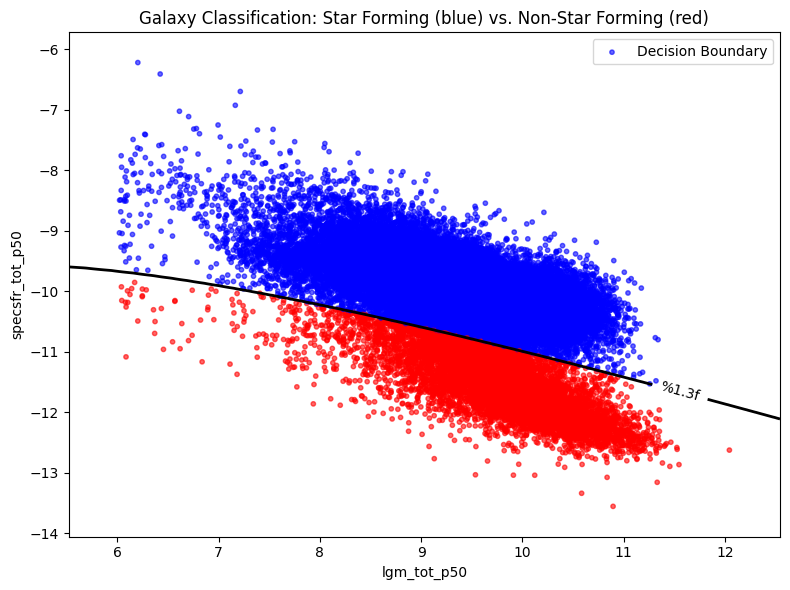

   lgm_tot_p50  specsfr_tot_p50  is_star_forming  posterior_star
0     9.590242        -9.879531             True    9.999961e-01
1     8.880196       -10.022780             True    9.982975e-01
2     9.627593       -10.202510             True    9.997907e-01
3    10.298320       -12.596710            False    4.238349e-10
5     9.820428       -10.552180             True    9.932672e-01


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

#--- Assume the best GMM results are in the dictionary `fit_results` from your previous code ---
# fit_results contains:
#   'means': list of two 2-element arrays (means for each component)
#   'covs': list of two 2x2 arrays (covariance matrices)
#   'weights': list of two weights
# For this example, we assume these variables are available.
# For clarity, we extract them:
means = fit_results['means']
covs = fit_results['covs']
weights = fit_results['weights']

#--- Decide which component corresponds to star forming:
# We assume the component with the higher value in sSFR (index 1) is star forming.
starforming_idx = np.argmax([m[1] for m in means])
nonstar_idx = 1 - starforming_idx

print("Star forming component index:", starforming_idx)
print("Non-star forming component index:", nonstar_idx)

#--- Now, for each galaxy in non_agn, compute posterior probabilities and add a new column.
# non_agn is the DataFrame with columns 'lgm_tot_p50' and 'specsfr_tot_p50'
X = non_agn[['lgm_tot_p50', 'specsfr_tot_p50']].values

# Function to compute component probability for one point
def compute_component_prob(x, comp_idx):
    return weights[comp_idx] * multivariate_normal.pdf(x, mean=means[comp_idx], cov=covs[comp_idx], allow_singular=True)

# Compute probabilities and assign class label
star_forming = []  # True if star forming, False if not

# Also, for clarity, store the maximum probability (posterior) if desired.
posterior = []

for x in X:
    p_star = compute_component_prob(x, starforming_idx)
    p_nonstar = compute_component_prob(x, nonstar_idx)
    if p_star >= p_nonstar:
        star_forming.append(True)
        posterior.append(p_star/(p_star+p_nonstar))
    else:
        star_forming.append(False)
        posterior.append(p_star/(p_star+p_nonstar))

# Add the classification to the DataFrame
non_agn = non_agn.copy()  # in case it isn't already
non_agn['is_star_forming'] = star_forming
non_agn['posterior_star'] = posterior

#--- Next, plot a scatter of the data colored by the classification.
plt.figure(figsize=(8, 6))
colors = non_agn['is_star_forming'].map({True: 'blue', False: 'red'})
plt.scatter(non_agn['lgm_tot_p50'], non_agn['specsfr_tot_p50'], c=colors, s=10, alpha=0.6)
plt.xlabel('lgm_tot_p50')
plt.ylabel('specsfr_tot_p50')
plt.title('Galaxy Classification: Star Forming (blue) vs. Non-Star Forming (red)')

#--- Compute and draw the decision boundary.
# The decision boundary is where the two component densities are equal.
# We compute it on a grid over the data range.

x_min, x_max = non_agn['lgm_tot_p50'].min() - 0.5, non_agn['lgm_tot_p50'].max() + 0.5
y_min, y_max = non_agn['specsfr_tot_p50'].min() - 0.5, non_agn['specsfr_tot_p50'].max() + 0.5

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid_points = np.column_stack([xx.ravel(), yy.ravel()])

# For each grid point, compute the difference between the two component densities:
p_star_grid = weights[starforming_idx] * multivariate_normal.pdf(grid_points, mean=means[starforming_idx], cov=covs[starforming_idx], allow_singular=True)
p_nonstar_grid = weights[nonstar_idx] * multivariate_normal.pdf(grid_points, mean=means[nonstar_idx], cov=covs[nonstar_idx], allow_singular=True)
pdf_diff = p_star_grid - p_nonstar_grid
pdf_diff = pdf_diff.reshape(xx.shape)

# Plot the 0 contour (decision boundary)
contour = plt.contour(xx, yy, pdf_diff, levels=[0], colors='black', linewidths=2)
plt.clabel(contour, fmt={'0': 'Decision Boundary'}, inline=True, fontsize=10)

plt.legend(['Decision Boundary', 'Star Forming', 'Non-Star Forming'], loc='best')
plt.tight_layout()
plt.show()

#--- Optionally, print a summary of the classification:
print(non_agn[['lgm_tot_p50', 'specsfr_tot_p50', 'is_star_forming', 'posterior_star']].head())

Fitting 3-component GMM using KL divergence minimization...
Best KL divergence: 2.0310
Component 1: weight=0.689, mean=[ 9.35064027 -9.84751111], cov=
[[ 0.32351389 -0.12891887]
 [-0.12891887  0.11579629]]
Component 2: weight=0.088, mean=[ 10.0336046  -11.78284654], cov=
[[ 0.24336888 -0.1555319 ]
 [-0.1555319   0.17029973]]
Component 3: weight=0.223, mean=[  9.09716415 -10.23259351], cov=
[[ 0.75007157 -0.46600664]
 [-0.46600664  0.75879126]]

Class counts:
class
star forming    44417
green valley     8403
quenched         5605
Name: count, dtype: int64


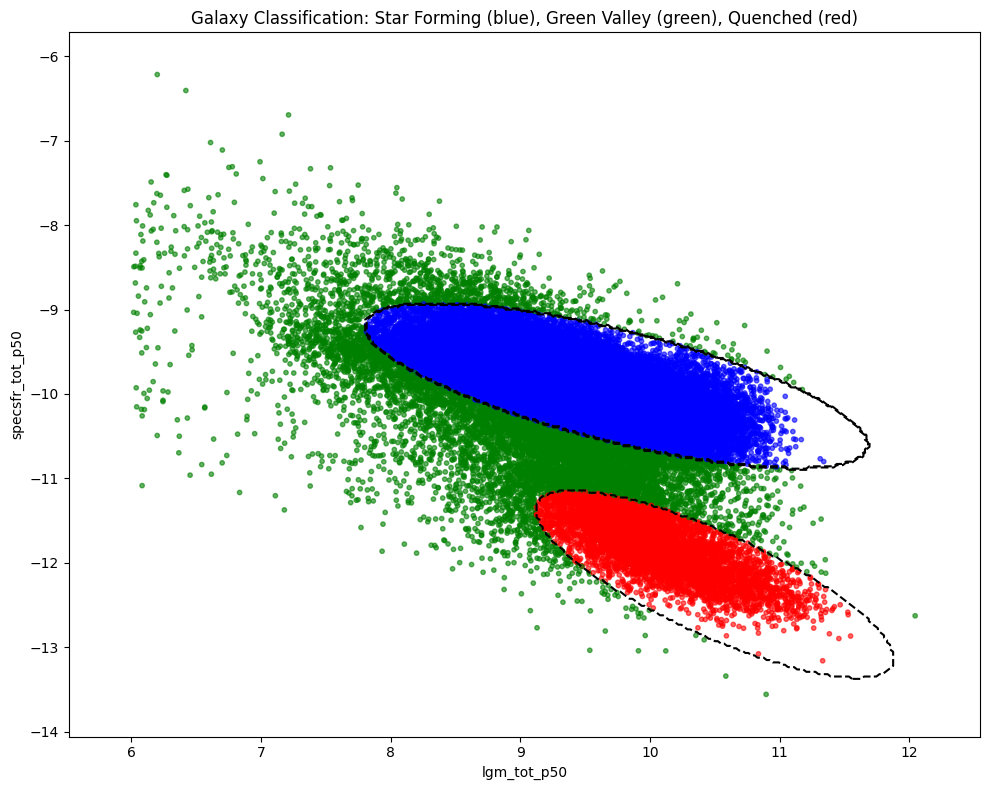

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from matplotlib.colors import ListedColormap

#--------------------------------------------------------------------
# 1. Define functions for a 3-component GMM with KL divergence
#--------------------------------------------------------------------
def params_to_gmm_3(params):
    """
    Convert a flat parameter vector (length 18) into 3 GMM components.
    For each component, parameters:
      - 2 for the mean,
      - 3 for covariance (Cholesky: [log(L00), L10, log(L11)]),
    Total for each: 5 params, for 3 components: 15.
    Then 3 parameters for weights (softmax).
    """
    means = []
    covs = []
    for i in range(3):
        base = 5 * i
        mu = np.array([params[base], params[base+1]])
        L00 = np.exp(params[base+2])
        L10 = params[base+3]
        L11 = np.exp(params[base+4])
        L = np.array([[L00, 0],
                      [L10, L11]])
        cov = L @ L.T
        means.append(mu)
        covs.append(cov)
    # Weights: last 3 parameters; use softmax.
    w_raw = params[15:18]
    exp_w = np.exp(w_raw)
    weights = exp_w / np.sum(exp_w)
    return means, covs, weights

def gmm_pdf_3(X, means, covs, weights):
    """
    Compute the probability density of a 3-component GMM at points X.
    X is an array of shape (n_samples, 2).
    """
    pdf_values = np.zeros(X.shape[0])
    for i in range(3):
        pdf_values += weights[i] * multivariate_normal.pdf(X, mean=means[i], cov=covs[i], allow_singular=True)
    return pdf_values

def estimate_kl_divergence_3(X, means, covs, weights, n_bins=50):
    """
    Estimate KL divergence between the empirical density of X and the GMM.
    """
    hist, x_edges, y_edges = np.histogram2d(X[:, 0], X[:, 1], bins=n_bins, density=True)
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    X_grid, Y_grid = np.meshgrid(x_centers, y_centers)
    grid_points = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
    
    pdf_vals = gmm_pdf_3(grid_points, means, covs, weights).reshape(X_grid.shape)
    epsilon = 1e-10
    hist = hist + epsilon
    pdf_vals = pdf_vals + epsilon
    kl_div = np.sum(hist * np.log(hist / pdf_vals.T))
    return kl_div

def objective_3(params, X, n_bins=50):
    means, covs, weights = params_to_gmm_3(params)
    return estimate_kl_divergence_3(X, means, covs, weights, n_bins)

def fit_gmm_to_data_3(X, n_init=10, n_bins=50):
    """
    Fit a 3-component GMM to X via KL divergence minimization.
    Returns ((means, covs, weights), kl_div) for the best fit.
    """
    best_kl = np.inf
    best_params = None
    dim = 18  # 3*5 + 3
    data_cov = np.cov(X.T)
    for i in range(n_init):
        # Initialize means: choose three random points from X.
        idx = np.random.choice(len(X), 3, replace=False)
        init_means = X[idx, :]  # shape (3,2)
        init_params = []
        for j in range(3):
            # Use the chosen point as initial mean.
            init_params.extend([init_means[j, 0], init_means[j, 1]])
            # For covariance: use log(std) from data covariance diagonal.
            init_params.append(np.log(np.sqrt(data_cov[0, 0])))
            init_params.append(0.0)  # off-diagonal
            init_params.append(np.log(np.sqrt(data_cov[1, 1])))
        # Initialize weights parameters (for 3 components) as zeros (equal weight).
        init_params.extend([0.0, 0.0, 0.0])
        init_params = np.array(init_params)
        
        res = minimize(lambda p: objective_3(p, X, n_bins), init_params, method='L-BFGS-B', options={'maxiter':3000})
        if res.success and res.fun < best_kl:
            best_kl = res.fun
            best_params = res.x
    if best_params is None:
        raise RuntimeError("GMM fitting failed in all initializations.")
    return params_to_gmm_3(best_params), best_kl

#--------------------------------------------------------------------
# 2. Fit the 3-component GMM to the non-AGN data (X)
#--------------------------------------------------------------------
# Here, X is assumed to be an array of shape (n_samples, 2) from non_agn[['lgm_tot_p50','specsfr_tot_p50']]
# For example:
# X = non_agn[['lgm_tot_p50', 'specsfr_tot_p50']].values

# Fit the GMM:
print("Fitting 3-component GMM using KL divergence minimization...")
gmm_result, kl_div = fit_gmm_to_data_3(X, n_init=10, n_bins=50)
(means_3, covs_3, weights_3) = gmm_result
print(f"Best KL divergence: {kl_div:.4f}")
for i in range(3):
    print(f"Component {i+1}: weight={weights_3[i]:.3f}, mean={means_3[i]}, cov=\n{covs_3[i]}")

#--------------------------------------------------------------------
# 3. Classify galaxies into three classes based on posterior probabilities
#--------------------------------------------------------------------
# For each galaxy, compute p_i = weight_i * N(x | mean_i, cov_i)
# Then assign the class corresponding to the maximum probability.
def classify_galaxy(x, means, covs, weights):
    probs = np.array([weights[i] * multivariate_normal.pdf(x, mean=means[i], cov=covs[i], allow_singular=True)
                      for i in range(3)])
    return np.argmax(probs), probs

# Compute classifications:
classes = []
posteriors = []  # optionally store normalized posterior for the assigned component
for x in X:
    comp_idx, probs = classify_galaxy(x, means_3, covs_3, weights_3)
    # Normalize:
    norm_prob = probs / np.sum(probs)
    posteriors.append(norm_prob[comp_idx])
    classes.append(comp_idx)

# Now, we order the 3 components by their sSFR mean (index 1).
# Let the one with the highest sSFR be "star forming", the lowest "quenched",
# and the intermediate "green valley".
sSFR_means = [m[1] for m in means_3]
order = np.argsort(sSFR_means)  # ascending: 0->lowest sSFR, 2->highest sSFR

# Build a mapping: component in original numbering -> class label.
# lowest: quenched, middle: green valley, highest: star forming.
label_map = { order[0]: 'quenched', order[1]: 'green valley', order[2]: 'star forming' }

# Create a classification list with labels:
class_labels = [ label_map[c] for c in classes ]

# Add these to the DataFrame non_agn
non_agn = non_agn.copy()  # avoid modifying original if not desired
non_agn['class'] = class_labels
non_agn['posterior'] = posteriors

print("\nClass counts:")
print(non_agn['class'].value_counts())

#--------------------------------------------------------------------
# 4. Plot the result with different colors and decision boundaries.
#--------------------------------------------------------------------
plt.figure(figsize=(10, 8))
# Color mapping: star forming (blue), green valley (green), quenched (red)
color_map = {'star forming': 'blue', 'green valley': 'green', 'quenched': 'red'}
colors = non_agn['class'].map(color_map)
plt.scatter(non_agn['lgm_tot_p50'], non_agn['specsfr_tot_p50'], c=colors, s=10, alpha=0.6)
plt.xlabel('lgm_tot_p50')
plt.ylabel('specsfr_tot_p50')
plt.title('Galaxy Classification: Star Forming (blue), Green Valley (green), Quenched (red)')

#--- Decision boundaries: compute for a grid the class with maximum probability.
x_min, x_max = non_agn['lgm_tot_p50'].min() - 0.5, non_agn['lgm_tot_p50'].max() + 0.5
y_min, y_max = non_agn['specsfr_tot_p50'].min() - 0.5, non_agn['specsfr_tot_p50'].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid_points = np.column_stack([xx.ravel(), yy.ravel()])

# For each grid point, compute the probability for each component.
pdf_vals = np.zeros((grid_points.shape[0], 3))
for i in range(3):
    pdf_vals[:, i] = weights_3[i] * multivariate_normal.pdf(grid_points, mean=means_3[i], cov=covs_3[i], allow_singular=True)
# Determine the class at each grid point.
grid_class = np.argmax(pdf_vals, axis=1)
grid_class = grid_class.reshape(xx.shape)

# Create a discrete colormap for the classes
cmap = ListedColormap([color_map[label_map[i]] for i in sorted(label_map.keys())])
# Draw the decision boundaries (contour where class changes)
plt.contour(xx, yy, grid_class, levels=[0.5, 1.5], colors='black', linestyles='--', linewidths=1.5)

plt.tight_layout()
plt.show()

Could not fit slice 8.179366329965465-8.479366329965465: The number of func parameters=6 must not exceed the number of data points=5


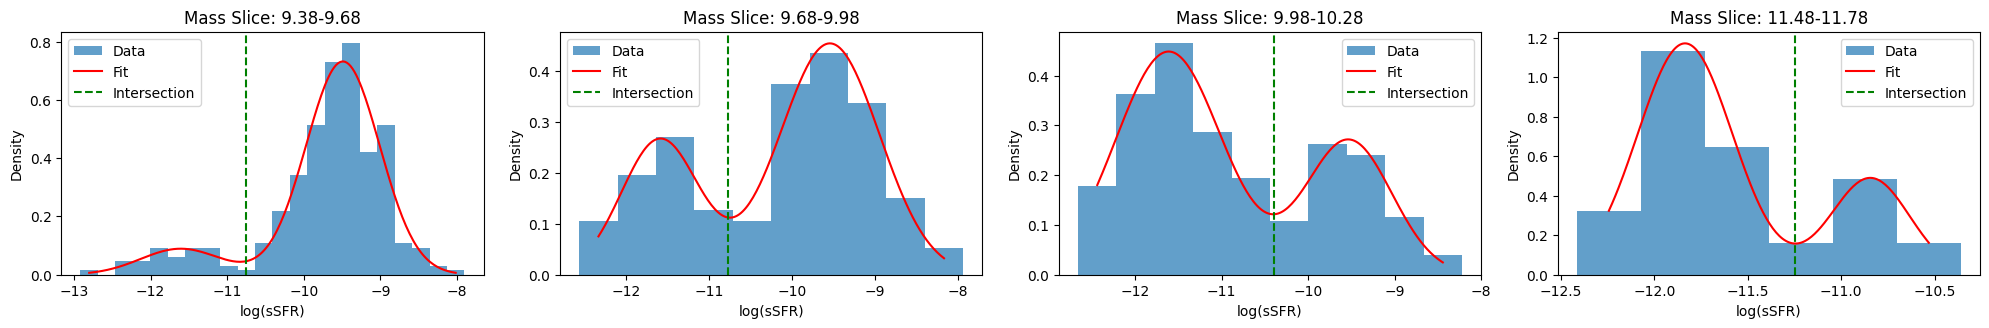

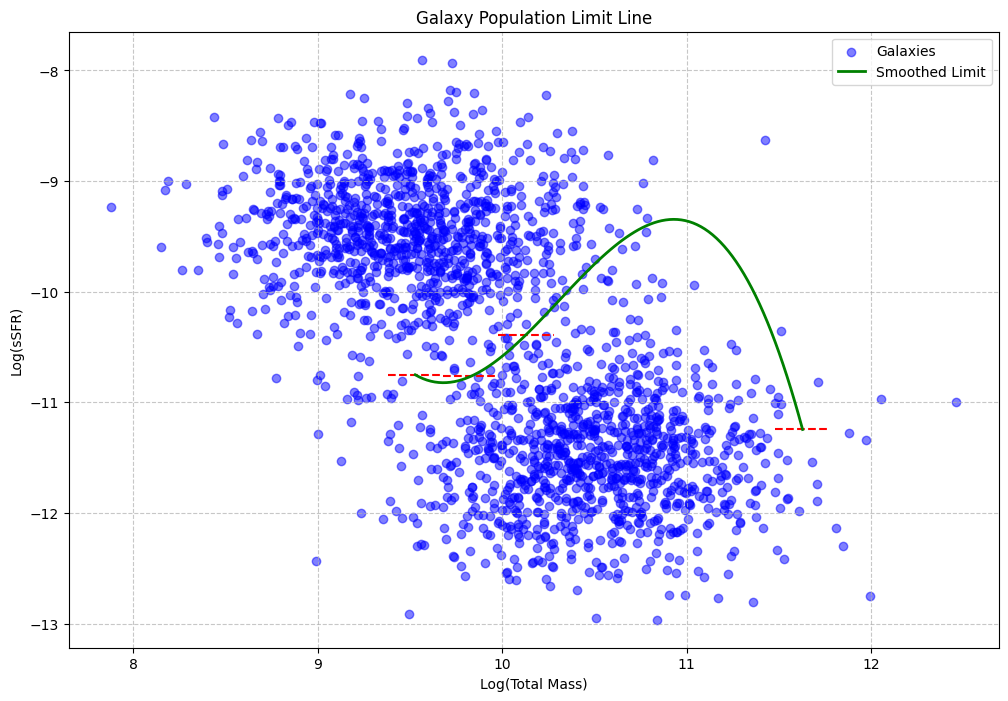

Mass Slices and Intersection Points:
Mass Range: 9.38-9.68, Intersection Point: -10.7511
Mass Range: 9.68-9.98, Intersection Point: -10.7657
Mass Range: 9.98-10.28, Intersection Point: -10.3901
Mass Range: 11.48-11.78, Intersection Point: -11.2454


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.optimize as optimize

def gaussian(x, amp1, cen1, sigma1, amp2, cen2, sigma2):
    """
    Sum of two Gaussian distributions
    """
    g1 = amp1 * np.exp(-(x - cen1)**2 / (2 * sigma1**2))
    g2 = amp2 * np.exp(-(x - cen2)**2 / (2 * sigma2**2))
    return g1 + g2

def gaussian_intersection(params):
    """
    Calculate the intersection point of two Gaussians
    """
    amp1, mu1, sigma1, amp2, mu2, sigma2 = params
    
    def equation(x):
        g1 = amp1 * np.exp(-((x - mu1)**2) / (2 * sigma1**2))
        g2 = amp2 * np.exp(-((x - mu2)**2) / (2 * sigma2**2))
        return g1 - g2
    
    try:
        intersection = optimize.brentq(
            equation, 
            min(mu1 - 4*sigma1, mu2 - 4*sigma2), 
            max(mu1 + 4*sigma1, mu2 + 4*sigma2)
        )
        return intersection
    except ValueError:
        return None

def slice_and_analyze_galaxies(df, x_col, y_col, slice_width=0.2):
    """
    Slice the galaxy data by total mass and fit two Gaussians to each slice
    """
    # Determine mass range
    mass_min = df[x_col].min()
    mass_max = df[x_col].max()
    
    # Prepare results storage
    results = {
        'slices': [],
        'intersections': [],
        'fit_parameters': []
    }
    
    # Prepare plotting
    plt.figure(figsize=(20, 15))
    
    # Slice the data
    mass_slices = np.arange(mass_min, mass_max, slice_width)
    
    for i in range(len(mass_slices) - 1):
        # Define slice boundaries
        mass_low = mass_slices[i]
        mass_high = mass_slices[i+1]
        
        # Filter data for this slice
        slice_mask = (df[x_col] >= mass_low) & (df[x_col] < mass_high)
        slice_data = df.loc[slice_mask, y_col]
        
        # Skip if not enough data
        if len(slice_data) < 10:
            continue
        
        # Histogram of the slice
        hist, bin_edges = np.histogram(slice_data, bins='auto', density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        try:
            # Initial guess for parameters
            p0 = [
                max(hist)/2, np.percentile(slice_data, 25), np.std(slice_data),
                max(hist)/2, np.percentile(slice_data, 75), np.std(slice_data)
            ]
            
            # Fit two Gaussians
            popt, _ = curve_fit(gaussian, bin_centers, hist, p0=p0)
            
            # Find intersection
            intersection = gaussian_intersection(popt)
            
            if intersection is not None:
                # Store results
                results['slices'].append((mass_low, mass_high))
                results['intersections'].append(intersection)
                results['fit_parameters'].append(popt)
                
                # Plotting for each slice
                plt.subplot(5, 4, len(results['slices']))
                plt.hist(slice_data, bins='auto', density=True, alpha=0.7, label='Data')
                
                # Plotting fitted Gaussian
                x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 200)
                plt.plot(x_fit, gaussian(x_fit, *popt), 'r-', label='Fit')
                
                # Plot intersection point
                plt.axvline(intersection, color='green', linestyle='--', label='Intersection')
                
                plt.title(f'Mass Slice: {mass_low:.2f}-{mass_high:.2f}')
                plt.xlabel('log(sSFR)')
                plt.ylabel('Density')
                plt.legend()
        
        except Exception as e:
            print(f"Could not fit slice {mass_low}-{mass_high}: {e}")
    
    plt.tight_layout()
    plt.show()
    
    # Overall data visualization
    plt.figure(figsize=(12, 8))
    
    # Scatter plot of all data
    plt.scatter(df[x_col], df[y_col], alpha=0.5, c='blue', label='Galaxies')
    
    # Plot the limit lines from each slice
    for (mass_low, mass_high), intersection in zip(results['slices'], results['intersections']):
        plt.hlines(intersection, mass_low, mass_high, colors='red', linestyles='--')
    
    # Interpolate the limit line
    limit_masses = [np.mean(slice_range) for slice_range in results['slices']]
    limit_values = results['intersections']
    
    # Fit a smoothing line to the limit points
    limit_fit = np.polyfit(limit_masses, limit_values, 3)
    limit_func = np.poly1d(limit_fit)
    
    # Plot the smoothed limit line
    x_smooth = np.linspace(min(limit_masses), max(limit_masses), 100)
    plt.plot(x_smooth, limit_func(x_smooth), 'g-', linewidth=2, label='Smoothed Limit')
    
    plt.xlabel('Log(Total Mass)')
    plt.ylabel('Log(sSFR)')
    plt.title('Galaxy Population Limit Line')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    return results

# Example usage
def main():
    # Generate synthetic data mimicking galaxy populations
    np.random.seed(42)
    
    # Create two populations with some overlap
    n_galaxies = 2000
    
    # Star-forming population
    sf_mass = np.random.normal(9.5, 0.5, n_galaxies//2)
    sf_sfr = np.random.normal(-9.5, 0.5, n_galaxies//2)
    
    # Quenched population
    q_mass = np.random.normal(10.5, 0.5, n_galaxies//2)
    q_sfr = np.random.normal(-11.5, 0.5, n_galaxies//2)
    
    # Combine populations
    df = pd.DataFrame({
        'lgm_tot_p50': np.concatenate([sf_mass, q_mass]),
        'specsfr_tot_p50': np.concatenate([sf_sfr, q_sfr])
    })
    
    # Perform slicing and analysis
    results = slice_and_analyze_galaxies(
        df, 
        x_col='lgm_tot_p50', 
        y_col='specsfr_tot_p50', 
        slice_width=0.3
    )
    
    # Print results
    print("Mass Slices and Intersection Points:")
    for slice_range, intersection in zip(results['slices'], results['intersections']):
        print(f"Mass Range: {slice_range[0]:.2f}-{slice_range[1]:.2f}, "
              f"Intersection Point: {intersection:.4f}")

if __name__ == "__main__":
    main()

Could not fit slice 7.958732659930929-8.15873265993093: The number of func parameters=6 must not exceed the number of data points=5
Could not fit slice 8.15873265993093-8.35873265993093: The number of func parameters=6 must not exceed the number of data points=5
Could not fit slice 8.558732659930929-8.75873265993093: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Could not fit slice 9.15873265993093-9.35873265993093: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Could not fit slice 11.358732659930933-11.558732659930932: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Could not fit slice 11.558732659930932-11.758732659930931: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.


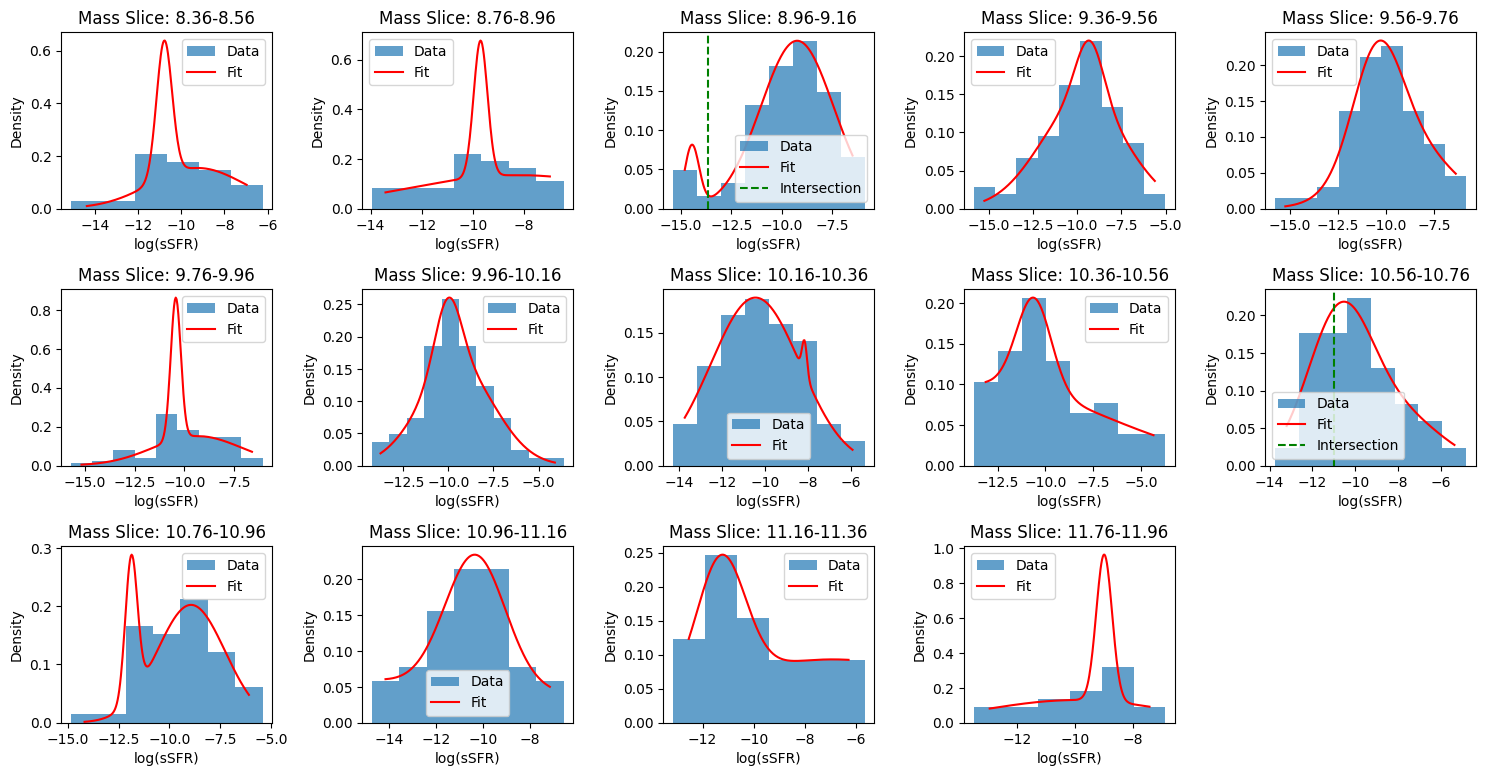

Mass Slices and Intersection Points:
Mass Range: 8.36-8.56, Intersection Point: None
Mass Range: 8.76-8.96, Intersection Point: None
Mass Range: 8.96-9.16, Intersection Point: -13.672429487592906
Mass Range: 9.36-9.56, Intersection Point: None
Mass Range: 9.56-9.76, Intersection Point: None
Mass Range: 9.76-9.96, Intersection Point: None
Mass Range: 9.96-10.16, Intersection Point: None
Mass Range: 10.16-10.36, Intersection Point: None
Mass Range: 10.36-10.56, Intersection Point: None
Mass Range: 10.56-10.76, Intersection Point: -11.000186430853056
Mass Range: 10.76-10.96, Intersection Point: None
Mass Range: 10.96-11.16, Intersection Point: None
Mass Range: 11.16-11.36, Intersection Point: None
Mass Range: 11.76-11.96, Intersection Point: None


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

def gaussian(x, amp1, cen1, sigma1, amp2, cen2, sigma2):
    """
    Sum of two Gaussian distributions
    
    Parameters:
    -----------
    x : array-like
        Input x values
    amp1, amp2 : float
        Amplitudes of the two Gaussians
    cen1, cen2 : float
        Centers of the two Gaussians
    sigma1, sigma2 : float
        Standard deviations of the two Gaussians
    
    Returns:
    --------
    array-like
        Sum of two Gaussian distributions
    """
    g1 = amp1 * np.exp(-(x - cen1)**2 / (2 * sigma1**2))
    g2 = amp2 * np.exp(-(x - cen2)**2 / (2 * sigma2**2))
    return g1 + g2

def find_intersection(popt):
    """
    Find the intersection point of two Gaussians
    
    Parameters:
    -----------
    popt : array-like
        Optimal parameters from curve_fit 
        [amp1, cen1, sigma1, amp2, cen2, sigma2]
    
    Returns:
    --------
    float
        x-coordinate of the intersection point
    """
    amp1, cen1, sigma1, amp2, cen2, sigma2 = popt
    
    # Analytical solution for intersection of two Gaussians
    # Solving g1 = g2
    a = 1/(2*sigma1**2) - 1/(2*sigma2**2)
    b = cen2/(sigma2**2) - cen1/(sigma1**2)
    c = (cen1**2)/(2*sigma1**2) - (cen2**2)/(2*sigma2**2) + \
        np.log((amp1*sigma2)/(amp2*sigma1))
    
    # Quadratic formula
    disc = b**2 - 4*a*c
    
    if disc < 0:
        return None
    
    x1 = (-b + np.sqrt(disc)) / (2*a)
    x2 = (-b - np.sqrt(disc)) / (2*a)
    
    return x1  # or x2, depending on which makes more sense

def slice_and_analyze_galaxies(df, x_col, y_col, slice_width=0.2):
    """
    Slice the galaxy data by total mass and fit two Gaussians to each slice
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with galaxy data
    x_col : str
        Column name for x-axis (total mass)
    y_col : str
        Column name for y-axis (specific star formation rate)
    slice_width : float, optional
        Width of each mass slice
    
    Returns:
    --------
    dict
        Slicing results with intersection points and fit parameters
    """
    # Determine mass range
    mass_min = df[x_col].min()
    mass_max = df[x_col].max()
    
    # Prepare results storage
    results = {
        'slices': [],
        'intersections': [],
        'fit_parameters': []
    }
    
    # Slice the data
    mass_slices = np.arange(mass_min, mass_max, slice_width)
    
    plt.figure(figsize=(15, 10))
    
    for i in range(len(mass_slices) - 1):
        # Define slice boundaries
        mass_low = mass_slices[i]
        mass_high = mass_slices[i+1]
        
        # Filter data for this slice
        slice_mask = (df[x_col] >= mass_low) & (df[x_col] < mass_high)
        slice_data = df.loc[slice_mask, y_col]
        
        # Skip if not enough data
        if len(slice_data) < 10:
            continue

        
        # Histogram of the slice
        hist, bin_edges = np.histogram(slice_data, bins='auto', density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        try:
            # Initial guess for parameters
            p0 = [
                max(hist)/2, np.mean(slice_data)-0.5, np.std(slice_data),
                max(hist)/2, np.mean(slice_data)+0.5, np.std(slice_data)
            ]
            
            # Fit two Gaussians
            popt, _ = curve_fit(gaussian, bin_centers, hist, p0=p0)
            
            # Find intersection
            intersection = find_intersection(popt)
            
            # Store results
            results['slices'].append((mass_low, mass_high))
            results['intersections'].append(intersection)
            results['fit_parameters'].append(popt)
            
            # Plotting
            plt.subplot(4, 5, len(results['slices']))
            plt.hist(slice_data, bins='auto', density=True, alpha=0.7, label='Data')
            x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 200)
            plt.plot(x_fit, gaussian(x_fit, *popt), 'r-', label='Fit')
            if intersection is not None:
                plt.axvline(intersection, color='green', linestyle='--', label='Intersection')
            plt.title(f'Mass Slice: {mass_low:.2f}-{mass_high:.2f}')
            plt.xlabel('log(sSFR)')
            plt.ylabel('Density')
            plt.legend()
        
        except Exception as e:
            print(f"Could not fit slice {mass_low}-{mass_high}: {e}")
    
    plt.tight_layout()
    plt.show()
    
    return results

# Example usage
def main():
    # Load your data (replace with your actual data loading method)
    # This is a placeholder - you'll need to modify this
    np.random.seed(42)
    df = pd.DataFrame({
        'lgm_tot_p50': np.random.normal(10, 1, 1000),
        'specsfr_tot_p50': np.random.normal(-10, 2, 1000)
    })
    
    # Perform slicing and analysis
    results = slice_and_analyze_galaxies(
        df, 
        x_col='lgm_tot_p50', 
        y_col='specsfr_tot_p50', 
        slice_width=0.2
    )
    
    # Print results
    print("Mass Slices and Intersection Points:")
    for slice_range, intersection in zip(results['slices'], results['intersections']):
        print(f"Mass Range: {slice_range[0]:.2f}-{slice_range[1]:.2f}, "
              f"Intersection Point: {intersection}")

if __name__ == "__main__":
    main()

Intersection candidates: [-9.0]
Selected intersection: -9.0
No exact intersection found. Closest point: -13.0
Intersection candidates: [-9.057351121159382]
Selected intersection: -9.057351121159382
Intersection candidates: [-8.95]
Selected intersection: -8.95
Intersection candidates: [-9.44890890990988]
Selected intersection: -9.44890890990988


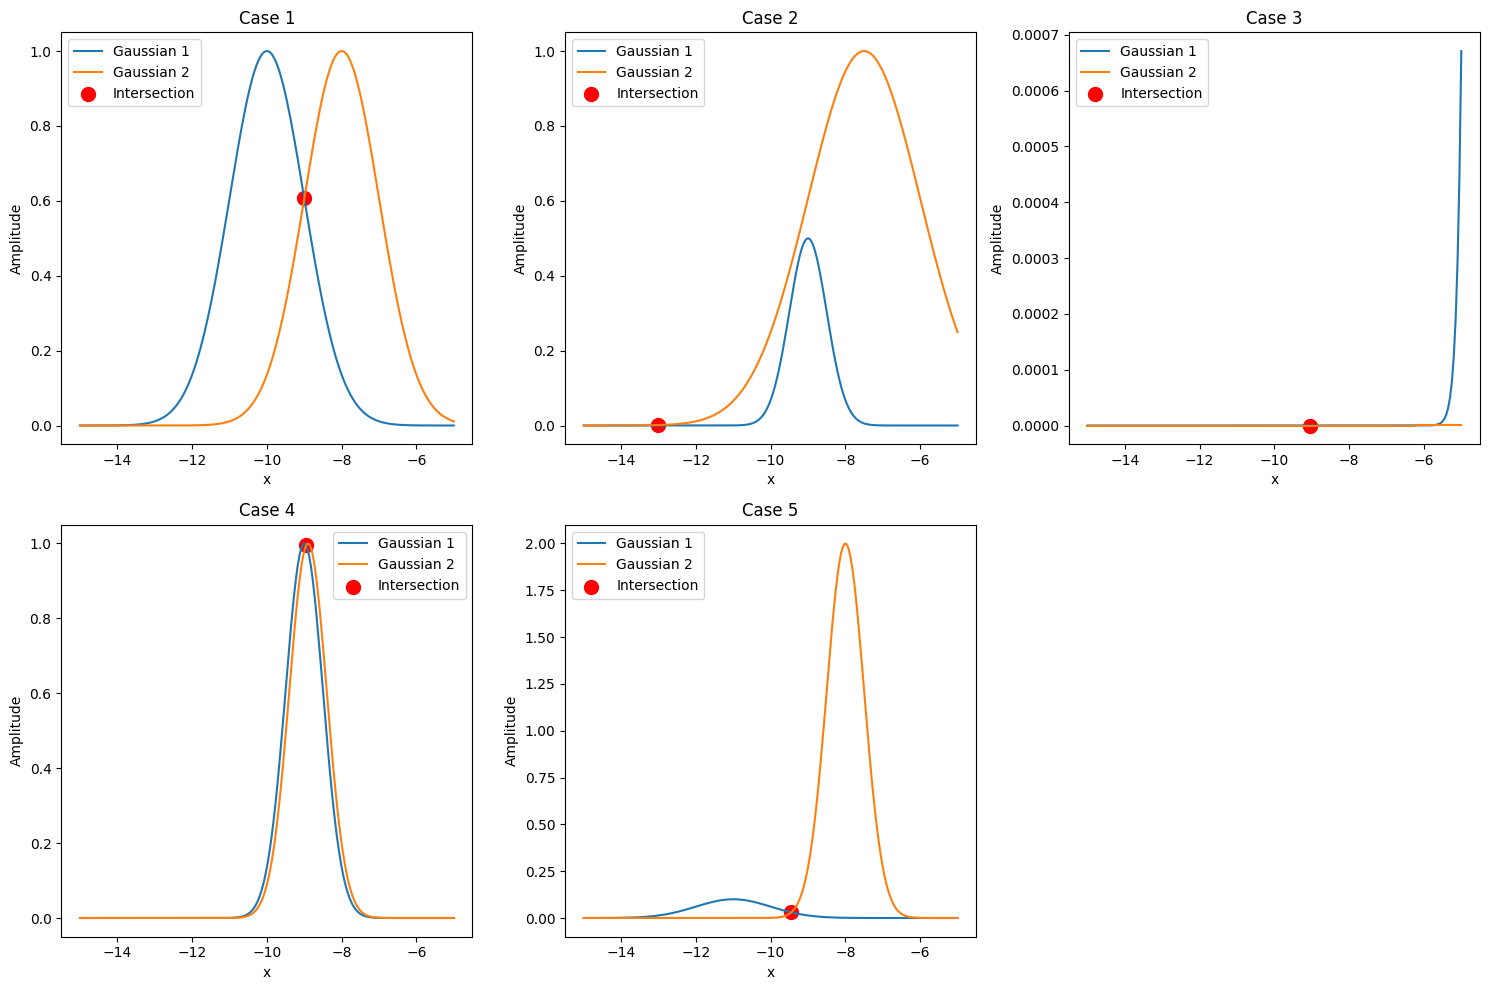

In [ ]:
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt



def test_gaussian_intersection():
    """
    Comprehensive testing of gaussian_intersection
    """
    # Test cases with different Gaussian characteristics
    test_cases = [
        # Symmetric Gaussians
        [1.0, -10.0, 1.0, 1.0, -8.0, 1.0],
        
        # Asymmetric Gaussians
        [0.5, -9.0, 0.5, 1.0, -7.5, 1.5],
        
        # Gaussians with intersection outside typical range
        [2.0, -3.0, 0.5, 1.0, 3.0, 1.0],
        
        # Closely centered Gaussians
        [1.0, -9.0, 0.5, 1.0, -8.9, 0.5],
        
        # Very different amplitudes
        [0.1, -11.0, 1.0, 2.0, -8.0, 0.5]
    ]
    
    plt.figure(figsize=(15, 10))
    
    for i, params in enumerate(test_cases, 1):
        # Find intersection
        intersection = gaussian_intersection(params, verbose=True)
        
        # Plotting
        plt.subplot(2, 3, i)
        
        # Unpack parameters
        amp1, mu1, sigma1, amp2, mu2, sigma2 = params
        
        # Generate x values
        x = np.linspace(-15, -5, 200)
        
        # Calculate Gaussian values
        g1 = amp1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
        g2 = amp2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2))
        
        # Plot Gaussians
        plt.plot(x, g1, label='Gaussian 1')
        plt.plot(x, g2, label='Gaussian 2')
        
        # Plot intersection if found
        if intersection is not None:
            plt.scatter(intersection, 
                        amp1 * np.exp(-(intersection - mu1)**2 / (2 * sigma1**2)), 
                        color='red', s=100, label='Intersection')
        
        plt.title(f'Case {i}')
        plt.xlabel('x')
        plt.ylabel('Amplitude')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Run the test
if __name__ == "__main__":
    test_gaussian_intersection()

Could not fit slice 6.619348-6.919347999999999: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Could not fit slice 6.919347999999999-7.219347999999999: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Could not fit slice 11.119347999999997-11.419347999999996: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.


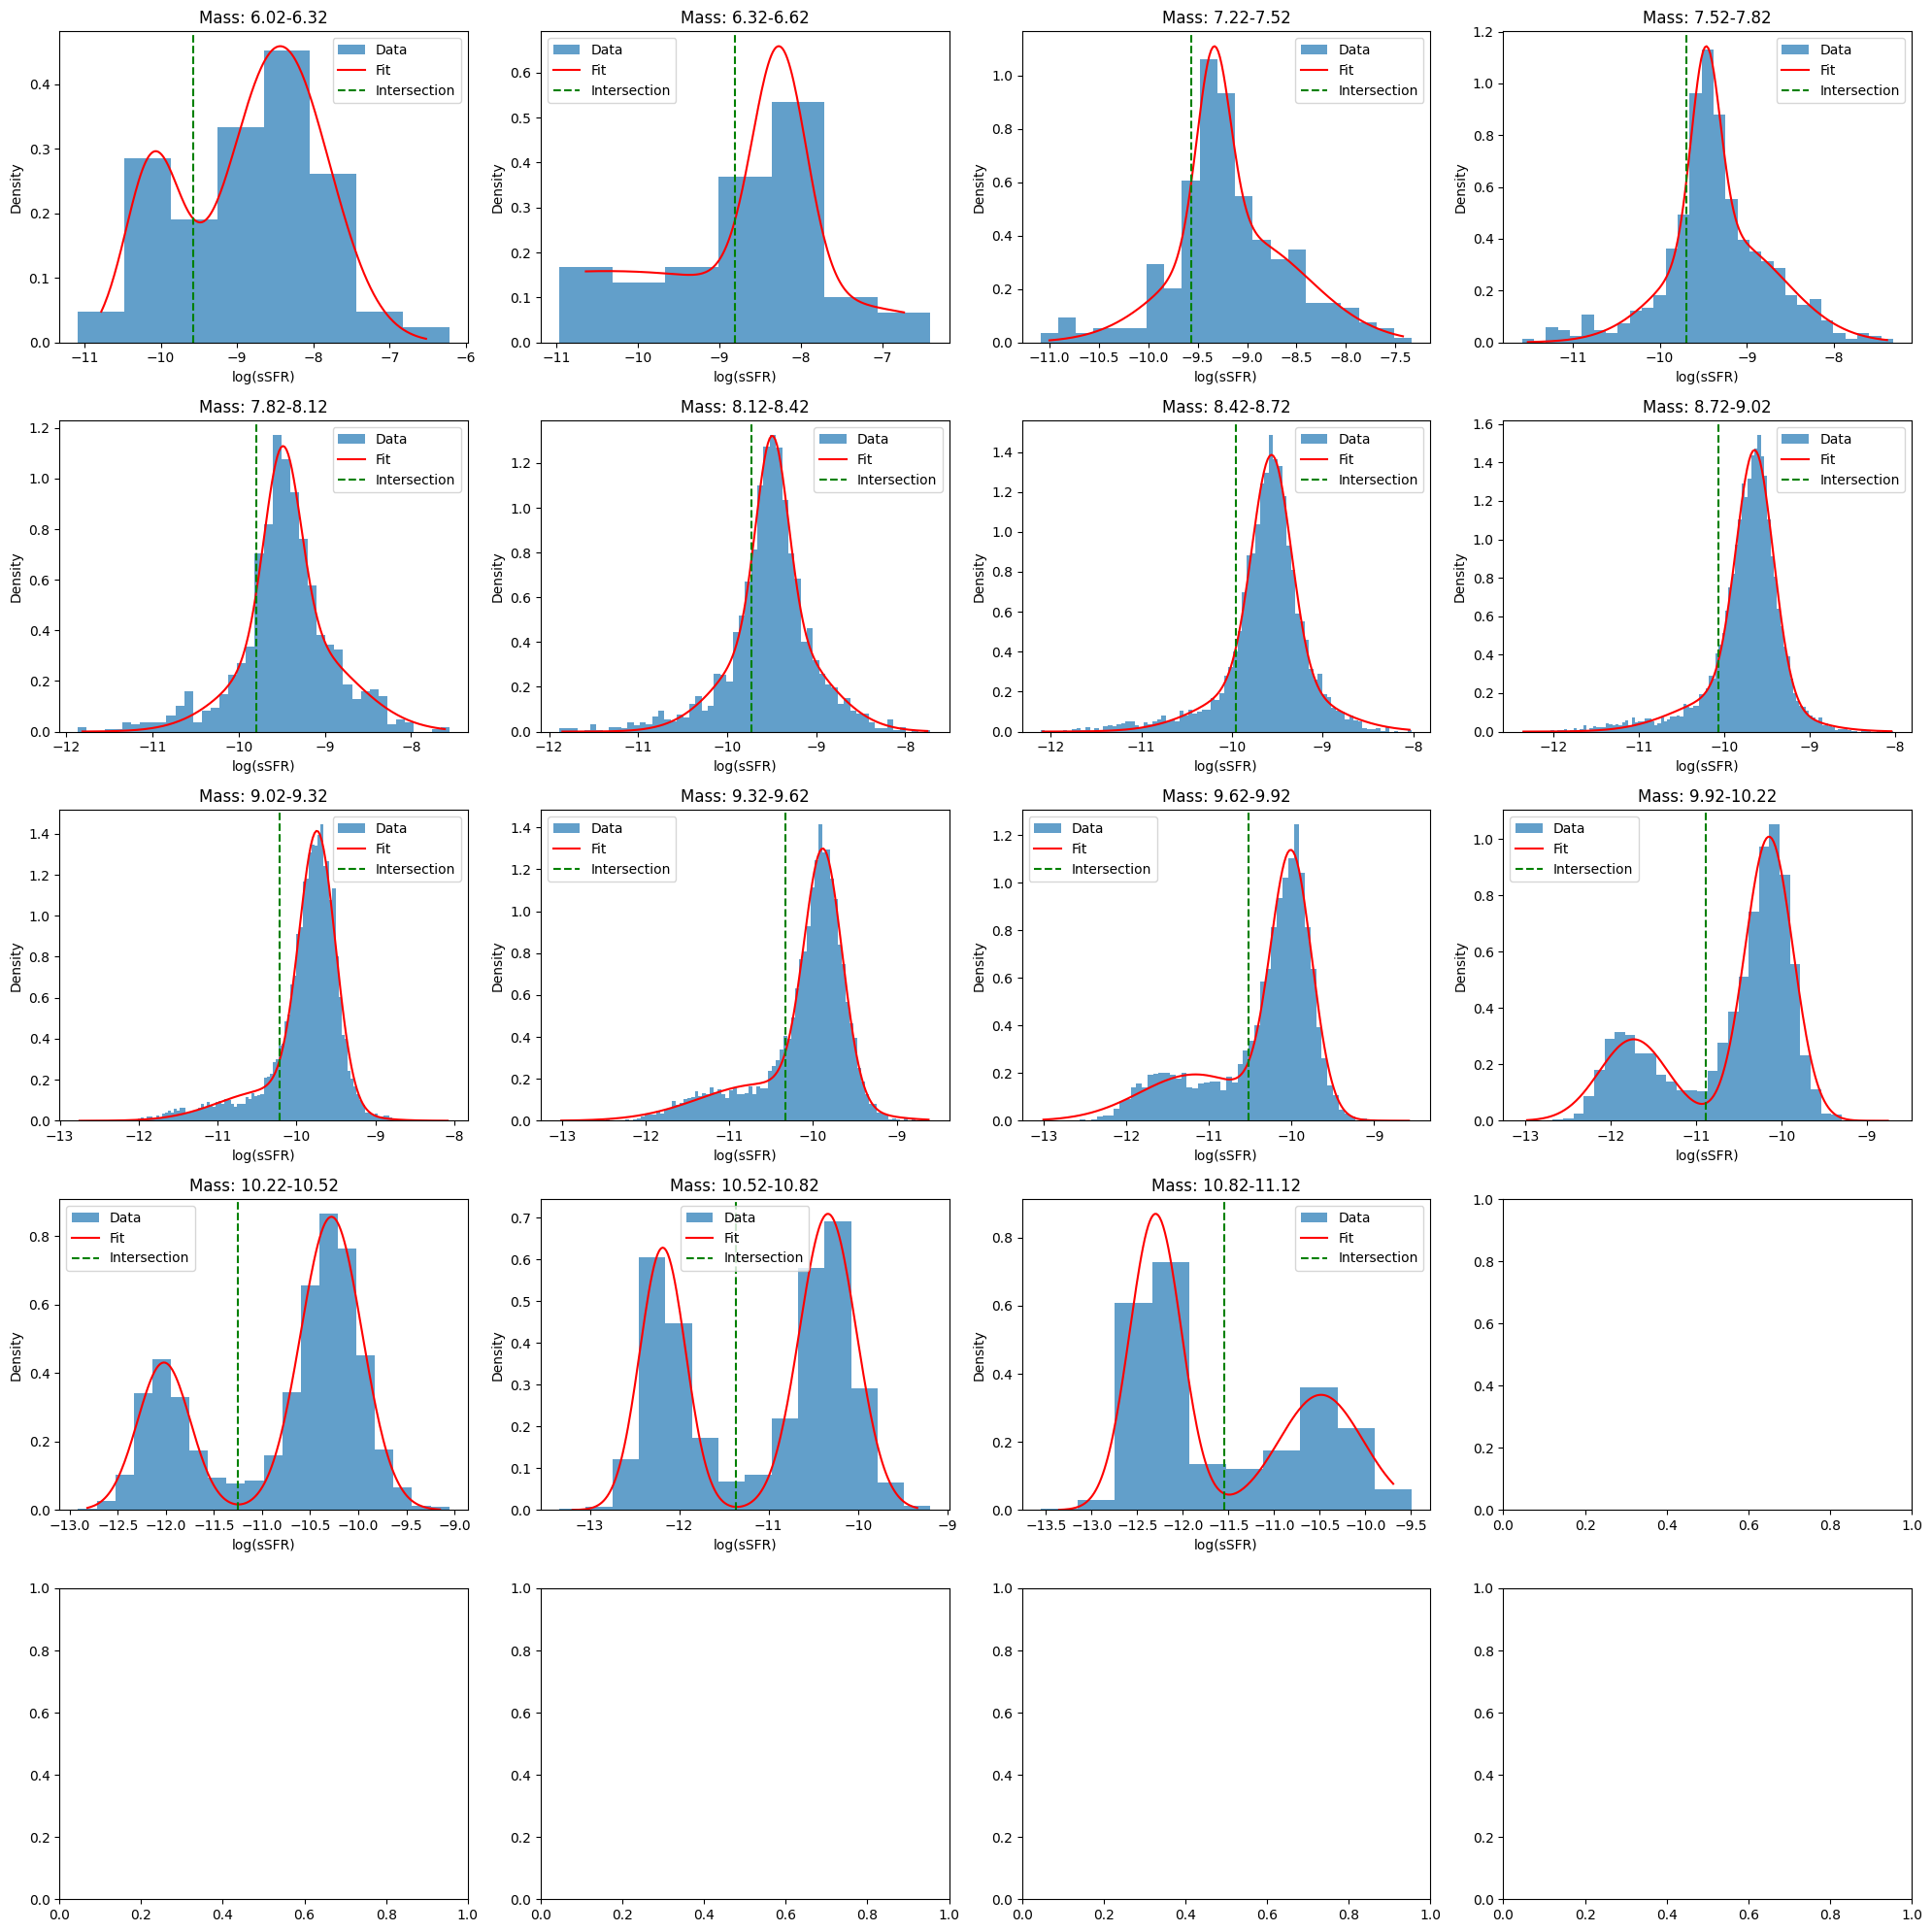

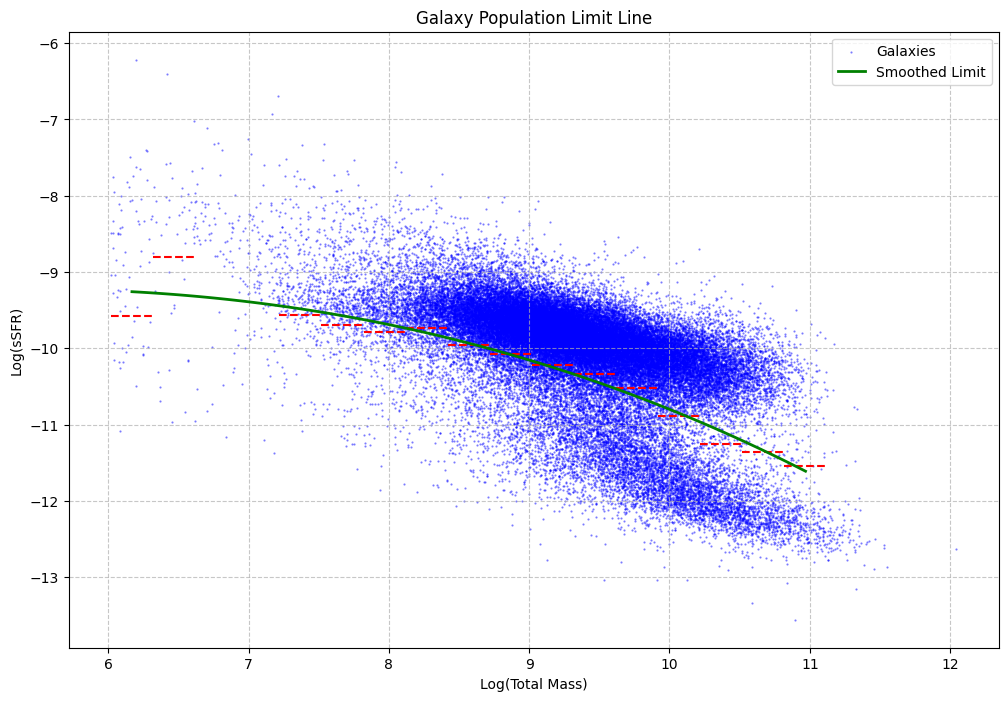

Mass Slices and Intersection Points:
Mass Range: 6.02-6.32, Intersection Point: -9.5727
Mass Range: 6.32-6.62, Intersection Point: -8.8090
Mass Range: 7.22-7.52, Intersection Point: -9.5646
Mass Range: 7.52-7.82, Intersection Point: -9.6928
Mass Range: 7.82-8.12, Intersection Point: -9.7929
Mass Range: 8.12-8.42, Intersection Point: -9.7298
Mass Range: 8.42-8.72, Intersection Point: -9.9579
Mass Range: 8.72-9.02, Intersection Point: -10.0690
Mass Range: 9.02-9.32, Intersection Point: -10.2180
Mass Range: 9.32-9.62, Intersection Point: -10.3315
Mass Range: 9.62-9.92, Intersection Point: -10.5226
Mass Range: 9.92-10.22, Intersection Point: -10.8871
Mass Range: 10.22-10.52, Intersection Point: -11.2490
Mass Range: 10.52-10.82, Intersection Point: -11.3657
Mass Range: 10.82-11.12, Intersection Point: -11.5437


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
import scipy.optimize as optimize
import warnings

def gaussian(x, amp1, cen1, sigma1, amp2, cen2, sigma2):
    """
    Sum of two Gaussian distributions
    """
    g1 = amp1 * np.exp(-(x - cen1)**2 / (2 * sigma1**2))
    g2 = amp2 * np.exp(-(x - cen2)**2 / (2 * sigma2**2))
    return g1 + g2

import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt

def gaussian_intersection(params, valid_range=(-13, -7), verbose=False):
    """
    Robust method to find intersection of two Gaussians with range validation
    
    Parameters:
    -----------
    params : array-like
        [amp1, mu1, sigma1, amp2, mu2, sigma2]
        amp: amplitude
        mu: mean
        sigma: standard deviation
    valid_range : tuple, optional
        Range to validate the intersection point
    verbose : bool, optional
        If True, print additional debugging information
    
    Returns:
    --------
    float or None
        Intersection point of the two Gaussians within valid range
    """
    amp1, mu1, sigma1, amp2, mu2, sigma2 = params
    
    def gaussian(x, amp, mu, sigma):
        """Single Gaussian function"""
        return amp * np.exp(-((x - mu)**2) / (2 * sigma**2))
    
    def difference_function(x):
        """Difference between two Gaussians"""
        return gaussian(x, amp1, mu1, sigma1) - gaussian(x, amp2, mu2, sigma2)
    
    # Generate a dense grid of points within the valid range
    grid_points = np.linspace(valid_range[0], valid_range[1], 200)
    
    # Compute Gaussian values for each point
    g1_values = gaussian(grid_points, amp1, mu1, sigma1)
    g2_values = gaussian(grid_points, amp2, mu2, sigma2)
    
    # Find where the sign changes or is very close
    diff_values = g1_values - g2_values
    
    # Identify potential intersection regions
    sign_changes = np.where(np.diff(np.sign(diff_values)))[0]
    
    # Best intersection candidates
    best_candidates = []
    
    for idx in sign_changes:
        # Interpolate to find more precise intersection
        x1, x2 = grid_points[idx], grid_points[idx+1]
        try:
            # Use more robust interpolation method
            intersection = optimize.brentq(difference_function, x1, x2)
            best_candidates.append(intersection)
        except (RuntimeError, ValueError):
            continue
    
    # If no candidates found, try alternative methods
    if not best_candidates:
        # Look for minimum absolute difference
        diff_abs = np.abs(diff_values)
        min_idx = np.argmin(diff_abs)
        candidate = grid_points[min_idx]
        
        if verbose:
            print(f"No exact intersection found. Closest point: {candidate}")
        
        # Only return if close enough
        if np.abs(g1_values[min_idx] - g2_values[min_idx]) < 0.01:
            return candidate
        
        return None
    
    # If multiple candidates, choose the one closest to the center of the range
    if best_candidates:
        range_center = np.mean(valid_range)
        intersection = min(best_candidates, key=lambda x: abs(x - range_center))
        
        if verbose:
            print(f"Intersection candidates: {best_candidates}")
            print(f"Selected intersection: {intersection}")
        
        return intersection
    
    return None


def slice_and_analyze_galaxies(df, x_col, y_col, slice_width=0.2, min_samples=20):
    """
    Slice the galaxy data by total mass and fit two Gaussians to each slice
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    x_col : str
        Column for x-axis (mass)
    y_col : str
        Column for y-axis (sSFR)
    slice_width : float, optional
        Width of each mass slice
    min_samples : int, optional
        Minimum number of samples required in a slice
    
    Returns:
    --------
    dict
        Analysis results
    """
    # Suppress warnings
    warnings.filterwarnings('ignore', category=OptimizeWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    
    # Determine mass range
    mass_min = df[x_col].min()
    mass_max = df[x_col].max()
    
    # Prepare results storage
    results = {
        'slices': [],
        'intersections': [],
        'fit_parameters': []
    }
    
    # Prepare plotting
    fig_slices, axes_slices = plt.subplots(5, 4, figsize=(20, 20))
    axes_slices = axes_slices.ravel()
    slice_plot_index = 0
    
    # Slice the data
    mass_slices = np.arange(mass_min, mass_max, slice_width)
    
    for i in range(len(mass_slices) - 1):
        # Define slice boundaries
        mass_low = mass_slices[i]
        mass_high = mass_slices[i+1]
        
        # Filter data for this slice
        slice_mask = (df[x_col] >= mass_low) & (df[x_col] < mass_high)
        slice_data = df.loc[slice_mask, y_col]
        
        # Skip if not enough data
        if len(slice_data) < min_samples:
            continue
        
        try:
            # Histogram of the slice with adaptive binning
            hist, bin_edges = np.histogram(slice_data, bins='auto', density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Require at least 6 data points for fitting
            if len(bin_centers) < 6:
                continue
            
            # Initial guess for parameters
            p0 = [
                max(hist)/2, np.percentile(slice_data, 25), np.std(slice_data),
                max(hist)/2, np.percentile(slice_data, 75), np.std(slice_data)
            ]
            
            # Fit two Gaussians
            popt, _ = curve_fit(gaussian, bin_centers, hist, p0=p0)
            
            # Find intersection
            intersection = gaussian_intersection(popt)
            
            if intersection is not None:
                # Store results
                results['slices'].append((mass_low, mass_high))
                results['intersections'].append(intersection)
                results['fit_parameters'].append(popt)
                
                # Plotting for each slice
                ax = axes_slices[slice_plot_index]
                ax.hist(slice_data, bins='auto', density=True, alpha=0.7, label='Data')
                
                # Plotting fitted Gaussian
                x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 200)
                ax.plot(x_fit, gaussian(x_fit, *popt), 'r-', label='Fit')
                
                # Plot intersection point
                ax.axvline(intersection, color='green', linestyle='--', label='Intersection')
                
                ax.set_title(f'Mass: {mass_low:.2f}-{mass_high:.2f}')
                ax.set_xlabel('log(sSFR)')
                ax.set_ylabel('Density')
                ax.legend()
                
                slice_plot_index += 1
                
                # Break if we've filled all subplot spaces
                if slice_plot_index >= 20:
                    break
        
        except Exception as e:
            print(f"Could not fit slice {mass_low}-{mass_high}: {e}")
    
    plt.tight_layout()
    plt.show()
    
    # Overall data visualization
    plt.figure(figsize=(12, 8))
    
    # Scatter plot of all data
    plt.scatter(df[x_col], df[y_col], alpha=0.5, c='blue', label='Galaxies',s=0.3)
    
    # Plot the limit lines from each slice
    for (mass_low, mass_high), intersection in zip(results['slices'], results['intersections']):
        plt.hlines(intersection, mass_low, mass_high, colors='red', linestyles='--')
    
    # Interpolate the limit line
    if results['slices']:
        limit_masses = [np.mean(slice_range) for slice_range in results['slices']]
        limit_values = results['intersections']
        
        # Fit a smoothing line to the limit points
        limit_fit = np.polyfit(limit_masses, limit_values, min(3, len(limit_masses)-1))
        limit_func = np.poly1d(limit_fit)
        
        # Plot the smoothed limit line
        x_smooth = np.linspace(min(limit_masses), max(limit_masses), 100)
        plt.plot(x_smooth, limit_func(x_smooth), 'g-', linewidth=2, label='Smoothed Limit')
    
    plt.xlabel('Log(Total Mass)')
    plt.ylabel('Log(sSFR)')
    plt.title('Galaxy Population Limit Line')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    return results

def main():
    
    # Perform slicing and analysis
    results = slice_and_analyze_galaxies(
        non_agn, 
        x_col='lgm_tot_p50', 
        y_col='specsfr_tot_p50', 
        slice_width=0.3,
        min_samples=30  # Increased minimum samples
    )
    
    # Print results
    print("Mass Slices and Intersection Points:")
    for slice_range, intersection in zip(results['slices'], results['intersections']):
        print(f"Mass Range: {slice_range[0]:.2f}-{slice_range[1]:.2f}, "
              f"Intersection Point: {intersection:.4f}")

if __name__ == "__main__":
    main()

Slice 6.019348-6.319348: 69 samples
   Fitting Gaussians...
   Intersection at -9.5727
Slice 6.319348-6.619348: 46 samples
   Fitting Gaussians...
   Intersection at -13553.9340
Slice 6.619348-6.919347999999999: 63 samples
   Fitting Gaussians...
Could not fit slice 6.619348-6.919347999999999: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Slice 6.919347999999999-7.219347999999999: 135 samples
   Fitting Gaussians...
Could not fit slice 6.919347999999999-7.219347999999999: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Slice 7.219347999999999-7.519347999999999: 305 samples
   Fitting Gaussians...
   Intersection at -9.1471
Slice 7.519347999999999-7.819347999999999: 604 samples
   Fitting Gaussians...
   Intersection at -9.2811
Slice 7.819347999999999-8.119347999999999: 1050 samples
   Fitting Gaussians...
   Intersection at -9.2213
Slice 8.119347999999999-8.419348: 2110 samples
   Fitting Gaussians...
   No int

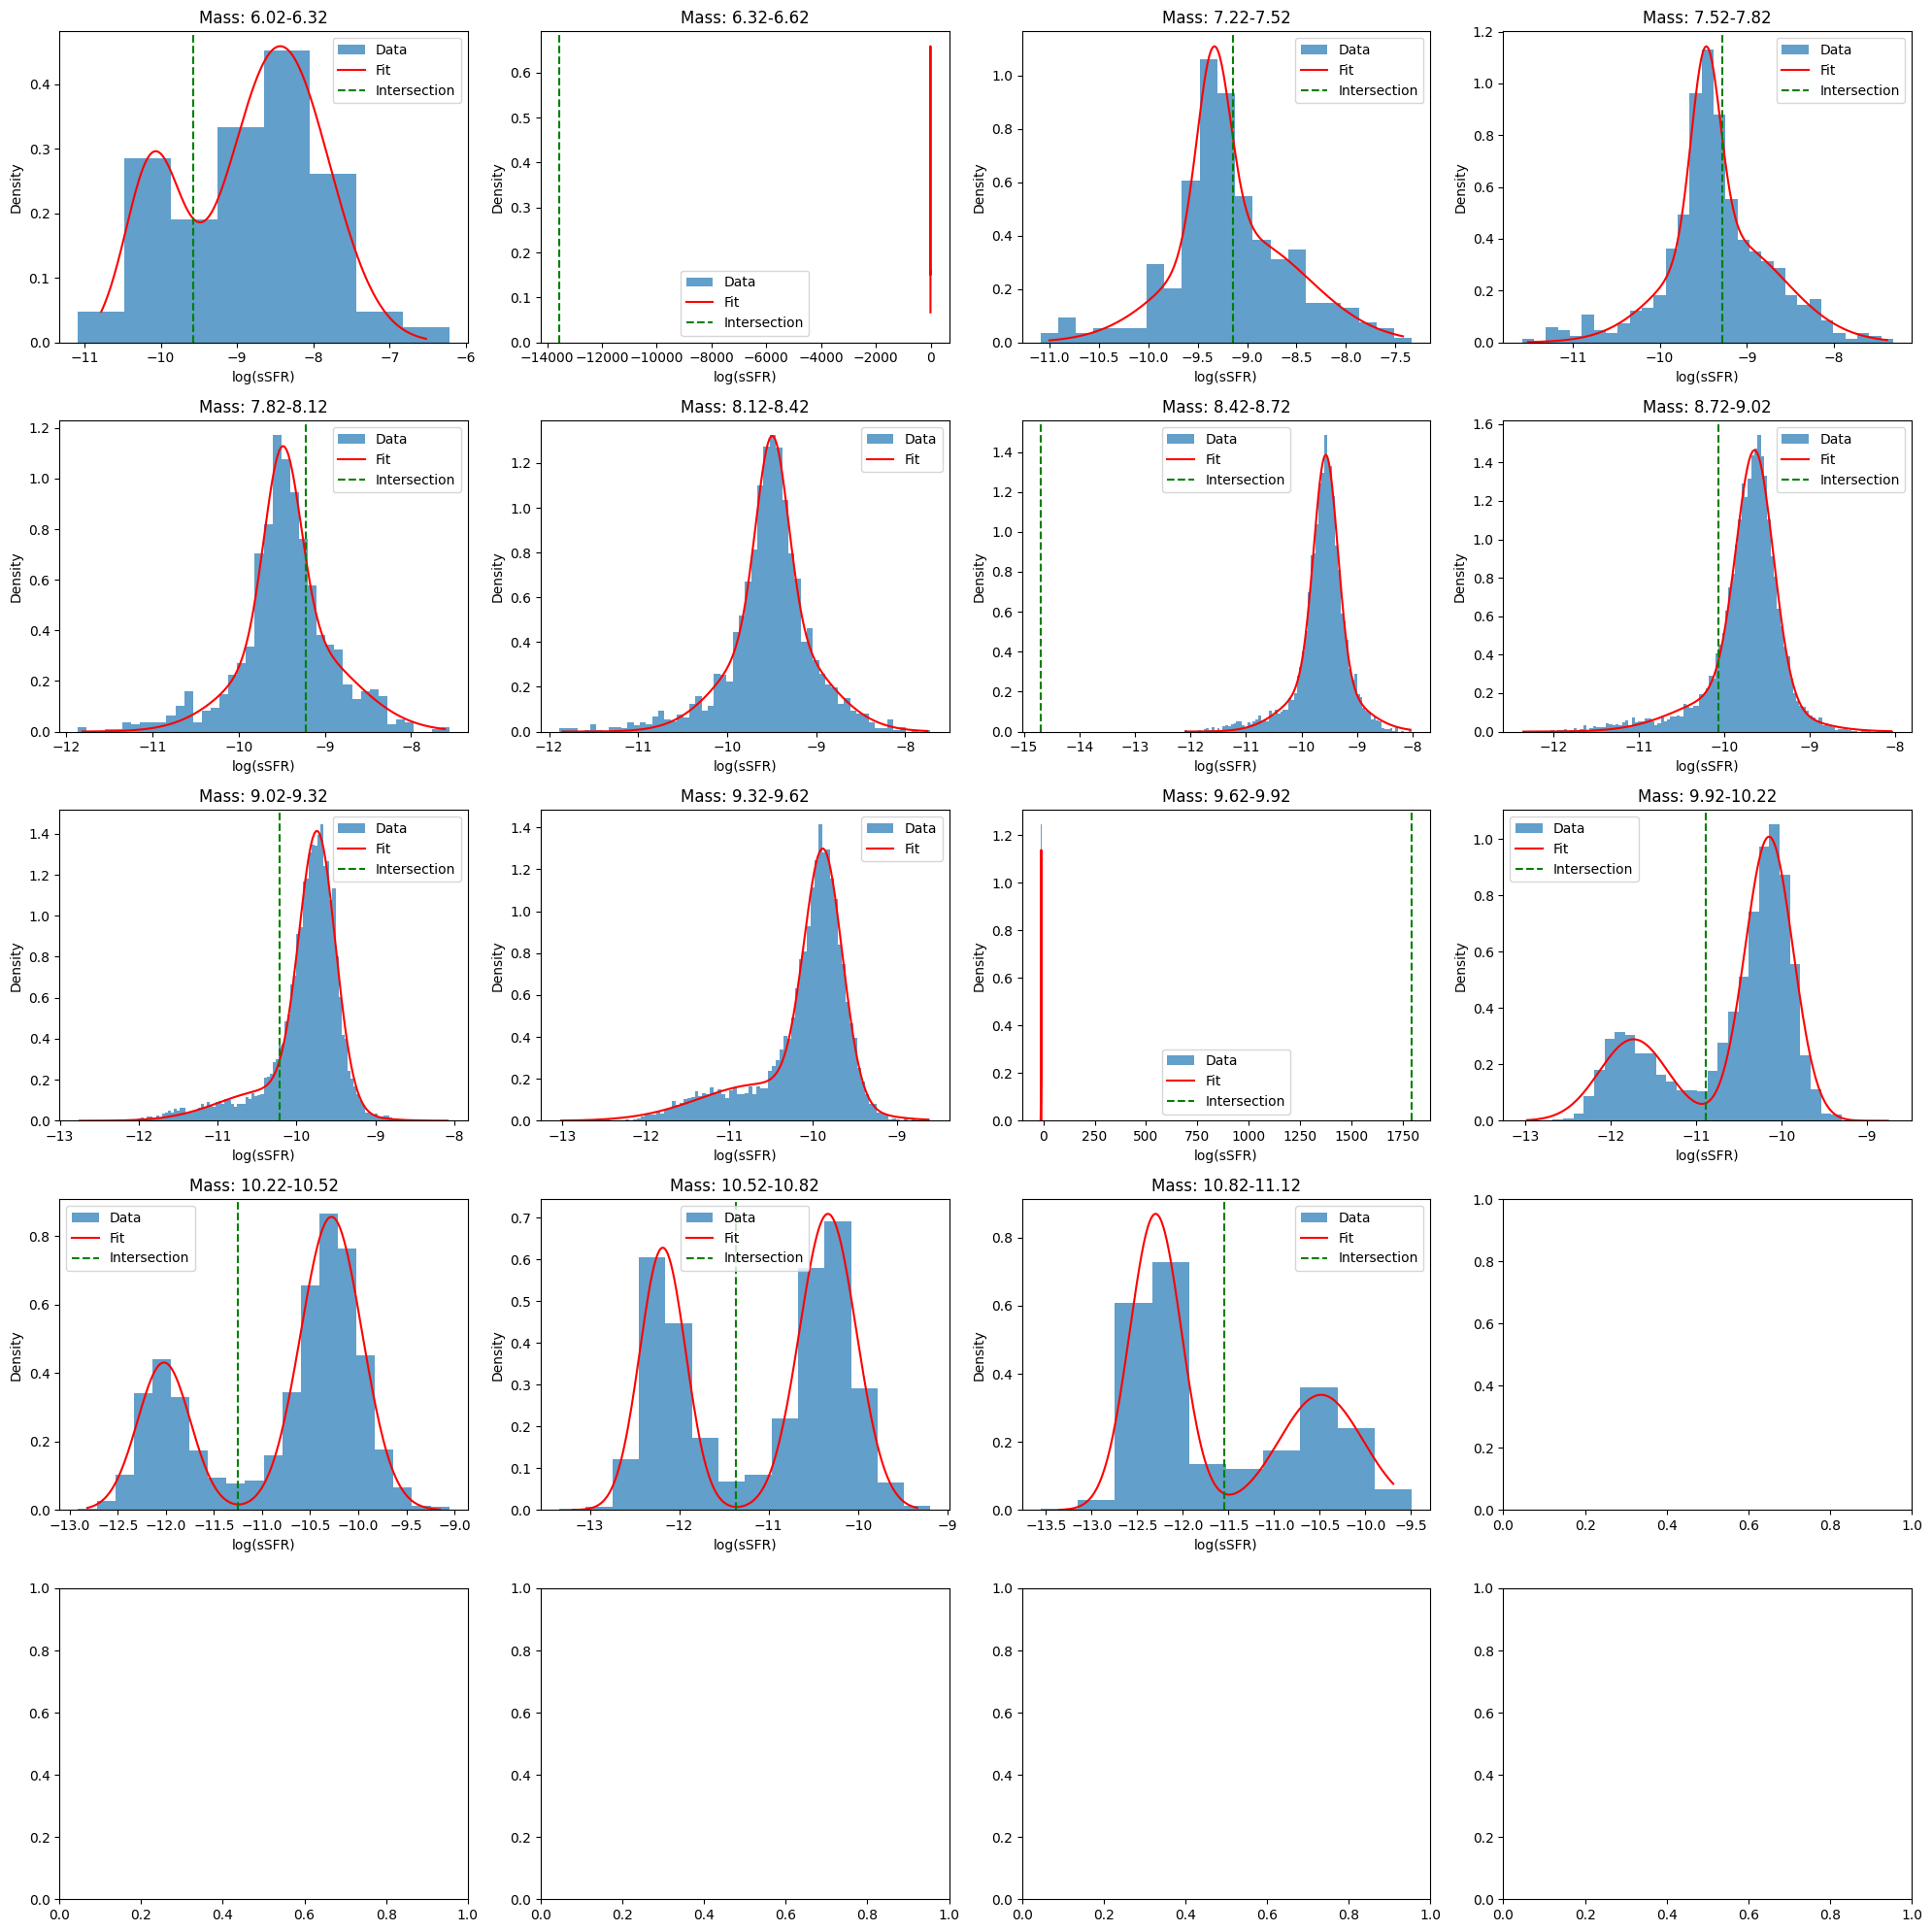

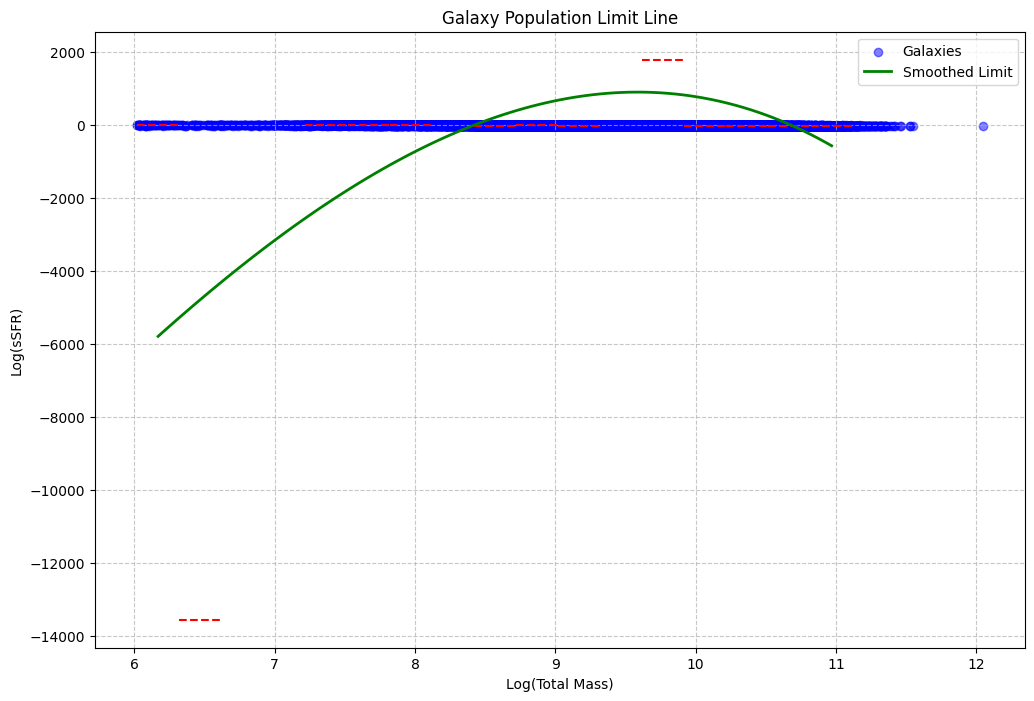

Mass Slices and Intersection Points:
Mass Range: 6.02-6.32, Intersection Point: -9.5727
Mass Range: 6.32-6.62, Intersection Point: -13553.9340
Mass Range: 7.22-7.52, Intersection Point: -9.1471
Mass Range: 7.52-7.82, Intersection Point: -9.2811
Mass Range: 7.82-8.12, Intersection Point: -9.2213
Mass Range: 8.42-8.72, Intersection Point: -14.6980
Mass Range: 8.72-9.02, Intersection Point: -10.0690
Mass Range: 9.02-9.32, Intersection Point: -10.2180
Mass Range: 9.62-9.92, Intersection Point: 1792.4550
Mass Range: 9.92-10.22, Intersection Point: -10.8871
Mass Range: 10.22-10.52, Intersection Point: -11.2490
Mass Range: 10.52-10.82, Intersection Point: -11.3657
Mass Range: 10.82-11.12, Intersection Point: -11.5437


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
import scipy.optimize as optimize
import warnings

def gaussian(x, amp1, cen1, sigma1, amp2, cen2, sigma2):
    """
    Sum of two Gaussian distributions
    """
    g1 = amp1 * np.exp(-(x - cen1)**2 / (2 * sigma1**2))
    g2 = amp2 * np.exp(-(x - cen2)**2 / (2 * sigma2**2))
    return g1 + g2

def gaussian_intersection(params, verbose=False):
    """
    Robust method to find intersection of two Gaussians
    
    Parameters:
    -----------
    params : array-like
        [amp1, mu1, sigma1, amp2, mu2, sigma2]
        amp: amplitude
        mu: mean
        sigma: standard deviation
    verbose : bool, optional
        If True, print additional debugging information
    
    Returns:
    --------
    float or None
        Intersection point of the two Gaussians
    """
    amp1, mu1, sigma1, amp2, mu2, sigma2 = params
    
    def gaussian(x, amp, mu, sigma):
        """Single Gaussian function"""
        return amp * np.exp(-((x - mu)**2) / (2 * sigma**2))
    
    def difference_function(x):
        """Difference between two Gaussians"""
        return gaussian(x, amp1, mu1, sigma1) - gaussian(x, amp2, mu2, sigma2)
    
    # Define search range
    # Use a range that covers most of both Gaussian distributions
    lower_bound = min(mu1 - 4*sigma1, mu2 - 4*sigma2)
    upper_bound = max(mu1 + 4*sigma1, mu2 + 4*sigma2)
    
    try:
        # Try root-finding methods in sequence
        methods = [
            lambda: optimize.brentq(difference_function, lower_bound, upper_bound),
            lambda: optimize.newton(difference_function, (lower_bound + upper_bound) / 2),
            lambda: optimize.bisect(difference_function, lower_bound, upper_bound)
        ]
        
        for method in methods:
            try:
                intersection = method()
                
                # Verify the intersection
                g1 = gaussian(intersection, amp1, mu1, sigma1)
                g2 = gaussian(intersection, amp2, mu2, sigma2)
                
                if verbose:
                    print(f"Intersection: {intersection}")
                    print(f"G1 value: {g1}")
                    print(f"G2 value: {g2}")
                    print(f"Difference: {abs(g1 - g2)}")
                
                return intersection
            
            except (RuntimeError, ValueError):
                continue
        
        # If all methods fail
        if verbose:
            print("Could not find intersection using standard methods")
        return None
    
    except Exception as e:
        if verbose:
            print(f"Unexpected error: {e}")
        return None

def slice_and_analyze_galaxies(df, x_col, y_col, slice_width=0.5, min_samples=8):
    """
    Slice the galaxy data by total mass and fit two Gaussians to each slice
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    x_col : str
        Column for x-axis (mass)
    y_col : str
        Column for y-axis (sSFR)
    slice_width : float, optional
        Width of each mass slice
    min_samples : int, optional
        Minimum number of samples required in a slice
    
    Returns:
    --------
    dict
        Analysis results
    """
    # Suppress warnings
    warnings.filterwarnings('ignore', category=OptimizeWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    
    # Determine mass range
    mass_min = df[x_col].min()
    mass_max = df[x_col].max()
    
    # Prepare results storage
    results = {
        'slices': [],
        'intersections': [],
        'fit_parameters': []
    }
    
    # Prepare plotting
    fig_slices, axes_slices = plt.subplots(5, 4, figsize=(20, 20))
    axes_slices = axes_slices.ravel()
    slice_plot_index = 0
    
    # Slice the data
    mass_slices = np.arange(mass_min, mass_max, slice_width)
    
    for i in range(len(mass_slices) - 1):
        # Define slice boundaries
        mass_low = mass_slices[i]
        mass_high = mass_slices[i+1]
        
        # Filter data for this slice
        slice_mask = (df[x_col] >= mass_low) & (df[x_col] < mass_high)
        slice_data = df.loc[slice_mask, y_col]
        
        # Skip if not enough data
        print(f"Slice {mass_low}-{mass_high}: {len(slice_data)} samples")
        if len(slice_data) < min_samples:
            continue
        
        try:
            print(f"   Fitting Gaussians...")
            # Histogram of the slice with adaptive binning
            hist, bin_edges = np.histogram(slice_data, bins='auto', density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Require at least 6 data points for fitting
            if len(bin_centers) < 6:
                continue
            
            # Initial guess for parameters
            p0 = [
                max(hist)/2, np.percentile(slice_data, 25), np.std(slice_data),
                max(hist)/2, np.percentile(slice_data, 75), np.std(slice_data)
            ]
            
            # Fit two Gaussians
            popt, _ = curve_fit(gaussian, bin_centers, hist, p0=p0)
            
            # Find intersection
            intersection = gaussian_intersection(popt)
            if intersection is not None:
                print(f"   Intersection at {intersection:.4f}")
            else:
                print("   No intersection found")

            # Plotting for each slice
            ax = axes_slices[slice_plot_index]
            ax.hist(slice_data, bins='auto', density=True, alpha=0.7, label='Data')
            
            # Plotting fitted Gaussian
            x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 200)
            ax.plot(x_fit, gaussian(x_fit, *popt), 'r-', label='Fit')
        
            
            if intersection is not None:
                # Store results
                results['slices'].append((mass_low, mass_high))
                results['intersections'].append(intersection)
                results['fit_parameters'].append(popt)
                
                
                # Plot intersection point
                ax.axvline(intersection, color='green', linestyle='--', label='Intersection')
                
                
                
                
                # Break if we've filled all subplot spaces
                if slice_plot_index > 20:
                    break
                
            slice_plot_index += 1

            ax.set_title(f'Mass: {mass_low:.2f}-{mass_high:.2f}')
            ax.set_xlabel('log(sSFR)')
            ax.set_ylabel('Density')
            ax.legend()
    
        except Exception as e:
            print(f"Could not fit slice {mass_low}-{mass_high}: {e}")
    
    plt.tight_layout()
    plt.show()
    
    # Overall data visualization
    plt.figure(figsize=(12, 8))
    
    # Scatter plot of all data
    plt.scatter(df[x_col], df[y_col], alpha=0.5, c='blue', label='Galaxies')
    
    # Plot the limit lines from each slice
    for (mass_low, mass_high), intersection in zip(results['slices'], results['intersections']):
        plt.hlines(intersection, mass_low, mass_high, colors='red', linestyles='--')
    
    # Interpolate the limit line
    if results['slices']:
        limit_masses = [np.mean(slice_range) for slice_range in results['slices']]
        limit_values = results['intersections']
        
        # Fit a smoothing line to the limit points
        limit_fit = np.polyfit(limit_masses, limit_values, min(3, len(limit_masses)-1))
        limit_func = np.poly1d(limit_fit)
        
        # Plot the smoothed limit line
        x_smooth = np.linspace(min(limit_masses), max(limit_masses), 100)
        plt.plot(x_smooth, limit_func(x_smooth), 'g-', linewidth=2, label='Smoothed Limit')
    
    plt.xlabel('Log(Total Mass)')
    plt.ylabel('Log(sSFR)')
    plt.title('Galaxy Population Limit Line')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    return results

def main():
    
    # Perform slicing and analysis
    results = slice_and_analyze_galaxies(
        non_agn, 
        x_col='lgm_tot_p50', 
        y_col='specsfr_tot_p50', 
        slice_width=0.3,
        min_samples=30  # Increased minimum samples
    )
    
    # Print results
    print("Mass Slices and Intersection Points:")
    for slice_range, intersection in zip(results['slices'], results['intersections']):
        print(f"Mass Range: {slice_range[0]:.2f}-{slice_range[1]:.2f}, "
              f"Intersection Point: {intersection:.4f}")

if __name__ == "__main__":
    main()

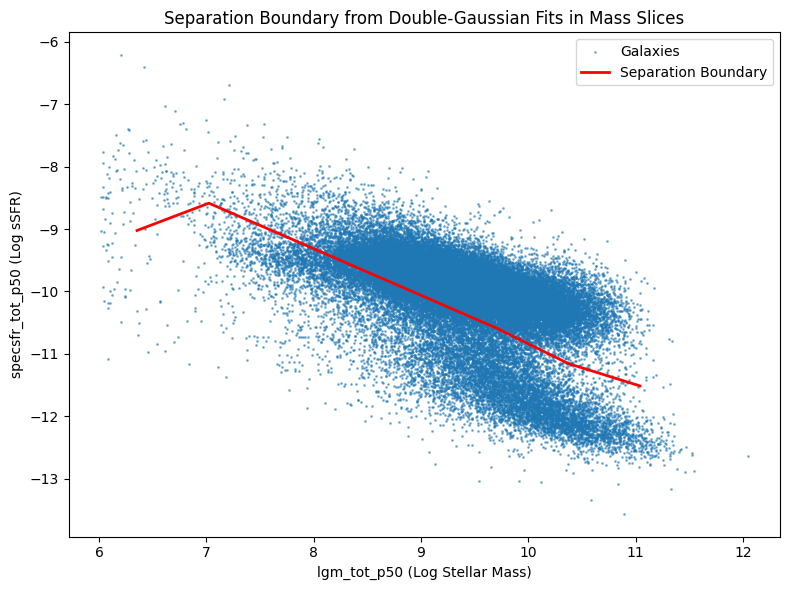

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, brentq

# Define the double Gaussian model
def double_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return A1 * np.exp(- (x - mu1)**2 / (2 * sigma1**2)) + \
           A2 * np.exp(- (x - mu2)**2 / (2 * sigma2**2))

# Load your dataset
data = pd.read_csv('non_agn.csv')
mass = data['lgm_tot_p50'].values
sSFR = data['specsfr_tot_p50'].values

# Define mass slices (adjust bin number or width as needed)
n_bins = 10
bin_edges = np.linspace(mass.min(), mass.max(), n_bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

boundary_points = []  # To store crossing points of the two Gaussians in each slice
mass_points = []      # To store the corresponding mass slice center

# Loop over each mass slice
for i in range(len(bin_edges) - 1):
    # Select galaxies in the current mass slice
    mask = (mass >= bin_edges[i]) & (mass < bin_edges[i+1])
    slice_sSFR = sSFR[mask]
    
    # Require a minimum number of points for a robust fit
    if len(slice_sSFR) < 20:
        continue
    
    # Create a histogram of sSFR in this slice
    n_hist_bins = 30
    hist_counts, hist_bins = np.histogram(slice_sSFR, bins=n_hist_bins, density=True)
    bin_centers_sSFR = 0.5 * (hist_bins[:-1] + hist_bins[1:])
    
    # Initial guesses for the two Gaussians:
    # Use percentiles as rough estimates for the means
    mu1_guess = np.percentile(slice_sSFR, 25)
    mu2_guess = np.percentile(slice_sSFR, 75)
    sigma_guess = np.std(slice_sSFR) / 2
    A1_guess = np.max(hist_counts)
    A2_guess = A1_guess / 2
    p0 = [A1_guess, mu1_guess, sigma_guess, A2_guess, mu2_guess, sigma_guess]
    
    try:
        popt, _ = curve_fit(double_gaussian, bin_centers_sSFR, hist_counts, p0=p0)
    except RuntimeError:
        continue
    
    A1, mu1, sigma1, A2, mu2, sigma2 = popt
    
    # Ensure mu1 is the lower sSFR peak and mu2 the higher one:
    if mu1 > mu2:
        A1, A2 = A2, A1
        mu1, mu2 = mu2, mu1
        sigma1, sigma2 = sigma2, sigma1
    
    # Define the two Gaussian components using the fitted parameters
    def gauss1(x):
        return A1 * np.exp(- (x - mu1)**2 / (2 * sigma1**2))/np.sqrt(2*np.pi*sigma1**2)
    def gauss2(x):
        return A2 * np.exp(- (x - mu2)**2 / (2 * sigma2**2))/np.sqrt(2*np.pi*sigma2**2)
    
    # Define the difference between the two Gaussians
    def diff(x):
        return gauss1(x) - gauss2(x)
    
    # Only attempt to find a crossing if the difference changes sign between mu1 and mu2
    if diff(mu1) * diff(mu2) < 0:
        try:
            crossing = brentq(diff, mu1, mu2)
            boundary_points.append(crossing)
            mass_points.append(0.5 * (bin_edges[i] + bin_edges[i+1]))
        except ValueError:
            pass

# Plot the results
plt.figure(figsize=(8,6))
# Scatter plot of all galaxies
plt.scatter(mass, sSFR, s=1, alpha=0.5, label='Galaxies')
# Plot the separation boundary (crossing points)
plt.plot(mass_points, boundary_points, 'r-', lw=2, label='Separation Boundary')
plt.xlabel('lgm_tot_p50 (Log Stellar Mass)')
plt.ylabel('specsfr_tot_p50 (Log sSFR)')
plt.title('Separation Boundary from Double-Gaussian Fits in Mass Slices')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: xlabel='lgm_tot_p50', ylabel='specsfr_tot_p50'>

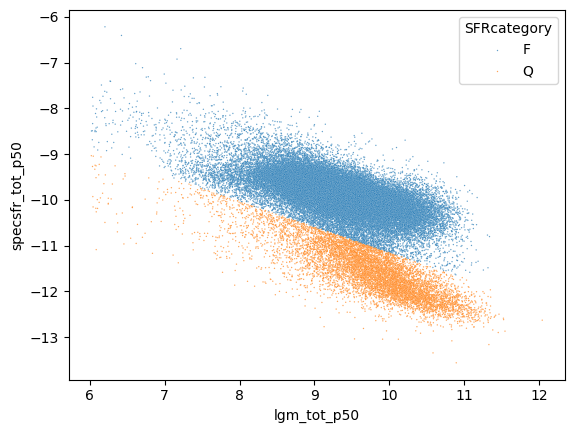

In [11]:
sns.scatterplot(data=non_agn, x='lgm_tot_p50', y='specsfr_tot_p50', hue='SFRcategory', alpha=0.7, s=1)
# a = -0.56
# b = -5.45
# x = np.linspace(6, 12, 100)
# y = a * x + b
# plt.plot(x, y, color='black', linestyle='--', label=f'$y = {a}x + {b}$')


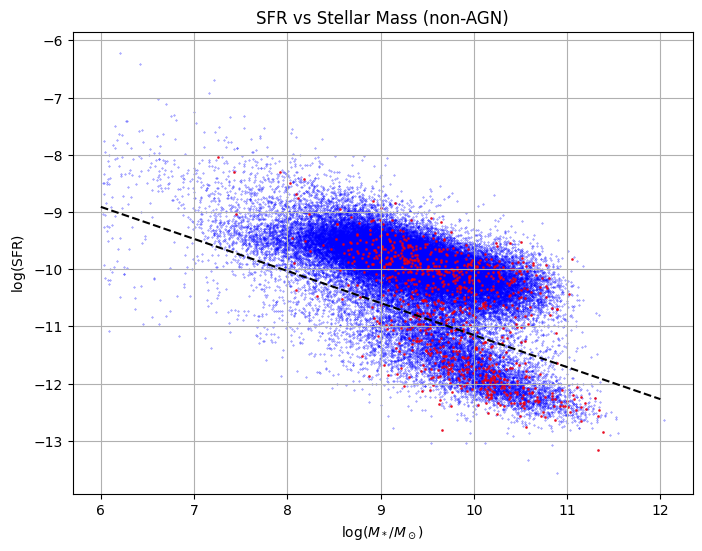

In [12]:
# Plot 'sfr_tot_p50' vs 'lgm_tot_p50' for non-AGN galaxies and HMCGs.

plt.figure(figsize=(8, 6))
plt.scatter(non_agn['lgm_tot_p50'], non_agn['specsfr_tot_p50'], color='blue', alpha=0.7, s=0.1)
plt.scatter(HMCG_sfr['lgm_tot_p50'], HMCG_sfr['specsfr_tot_p50'], color='red', alpha=0.7, s=1)

# Add a line having for equation y = a x + b
a = -0.56
b = -5.55
x = np.linspace(6, 12, 100)
y = a * x + b
plt.plot(x, y, color='black', linestyle='--', label=f'$y = {a}x + {b}$')

plt.xlabel(r'$\log(M_*/M_\odot)$')
plt.ylabel(r'$\log(\mathrm{SFR})$')
plt.title('SFR vs Stellar Mass (non-AGN)')
plt.grid(True)
# invert the y-axis
plt.show()

Means of the two Gaussian components:
 Component 1 mean = [  9.36951486 -10.73838122]
 Component 2 mean = [ 9.34799743 -9.83867065]

Covariance matrices of the two components:
 Component 1 covariance =
 [[ 0.77073459 -0.68730813]
 [-0.68730813  1.05096338]]

 Component 2 covariance =
 [[ 0.33852118 -0.13308681]
 [-0.13308681  0.11590976]]



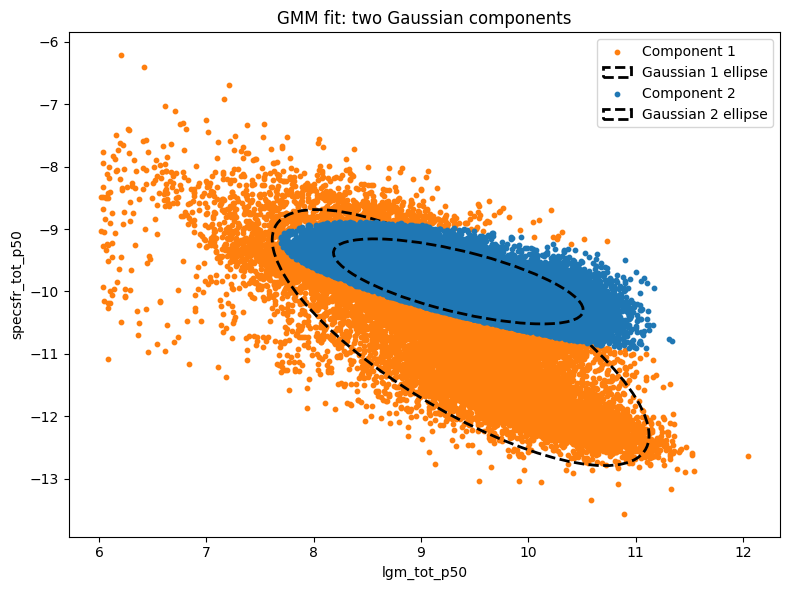

In [16]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# 1. Load dataset and extract relevant columns
data = non_agn
X = data[['lgm_tot_p50', 'specsfr_tot_p50']].values

# 2. Fit a 2-component Gaussian Mixture Model to the data
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
gmm.fit(X)

# 3. Output the means and covariances of the two Gaussian components
means = gmm.means_
covs = gmm.covariances_
print("Means of the two Gaussian components:")
for i, mean in enumerate(means, 1):
    print(f" Component {i} mean = {mean}")
print("\nCovariance matrices of the two components:")
for i, cov in enumerate(covs, 1):
    print(f" Component {i} covariance =\n {cov}\n")

# Predict cluster labels for each point (to color-code in plot)
labels = gmm.predict(X)

# 4. Create scatter plot of data colored by GMM cluster, with Gaussian ellipses
plt.figure(figsize=(8,6))
colors = ['tab:orange', 'tab:blue']
for j in range(2):
    pts = X[labels == j]
    plt.scatter(pts[:,0], pts[:,1], s=10, color=colors[j], label=f'Component {j+1}')
    # Ellipse for Gaussian j (2 standard deviations)
    eigvals, eigvecs = np.linalg.eigh(covs[j])
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:,order]
    theta = np.degrees(np.arctan2(eigvecs[1,0], eigvecs[0,0]))
    width, height = 2 * 2 * np.sqrt(eigvals)  # 2*sigma (2 standard deviations)
    ell = Ellipse(xy=means[j], width=width, height=height, angle=theta,
                  edgecolor='k', ls='--', facecolor='none', lw=2,
                  label=f'Gaussian {j+1} ellipse')
    plt.gca().add_patch(ell)
# Labeling the plot
plt.xlabel('lgm_tot_p50')        # Stellar mass (log M*)
plt.ylabel('specsfr_tot_p50')    # Specific SFR (log)
plt.title('GMM fit: two Gaussian components')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [28]:
import numpy as np
from sklearn.neighbors import KernelDensity

# Prepare data (dropping any NaNs)
data = non_agn[['lgm_tot_p50', 'specsfr_tot_p50']].dropna().to_numpy()

# Fit a Gaussian KDE (bandwidth can be adjusted or cross-validated)
kde = KernelDensity(bandwidth=0.2, kernel='gaussian').fit(data)

# Define a grid spanning the range of the data
mass_vals = np.linspace(data[:,0].min(), data[:,0].max(), 200)
sfr_vals  = np.linspace(data[:,1].min(), data[:,1].max(), 200)
M_grid, SFR_grid = np.meshgrid(mass_vals, sfr_vals)
grid_points = np.vstack([M_grid.ravel(), SFR_grid.ravel()]).T

# Evaluate KDE density on grid (log-density returned, so exponentiate)
log_dens = kde.score_samples(grid_points).reshape(M_grid.shape)
density  = np.exp(log_dens)

In [29]:
valley_points = []
for j, M_val in enumerate(mass_vals):
    col_density = density[:, j]
    # Find local minima in this column’s density
    for i in range(1, len(sfr_vals)-1):
        if col_density[i] < col_density[i-1] and col_density[i] < col_density[i+1]:
            valley_points.append((M_val, sfr_vals[i]))
            break  # take the first (highest sSFR) minimum if multiple

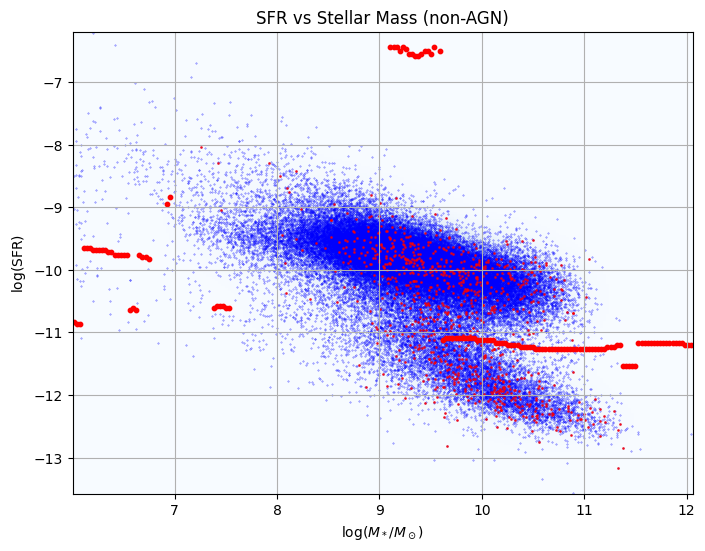

In [32]:
# Plot the KDE density and the valley points
plt.figure(figsize=(8, 6))
plt.pcolormesh(M_grid, SFR_grid, density, cmap='Blues', shading='auto')
plt.scatter(data[:,0], data[:,1], color='blue', alpha=0.7, s=0.1)
plt.scatter(HMCG_sfr['lgm_tot_p50'], HMCG_sfr['specsfr_tot_p50'], color='red', alpha=0.7, s=1)
valley_points = np.array(valley_points)
plt.scatter(valley_points[:,0], valley_points[:,1], color='red', s=10)
plt.xlabel(r'$\log(M_*/M_\odot)$')
plt.ylabel(r'$\log(\mathrm{SFR})$')
plt.title('SFR vs Stellar Mass (non-AGN)')
plt.grid(True)
plt.show()

<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\o'
/var/folders/2l/5qdg19zx40sdthfzpld2xpq80000gn/T/ipykernel_53348/84415129.py:10: SyntaxWarning: invalid escape sequence '\o'
  plt.title('SFR Distribution for $10^{9.5} M_\odot$')


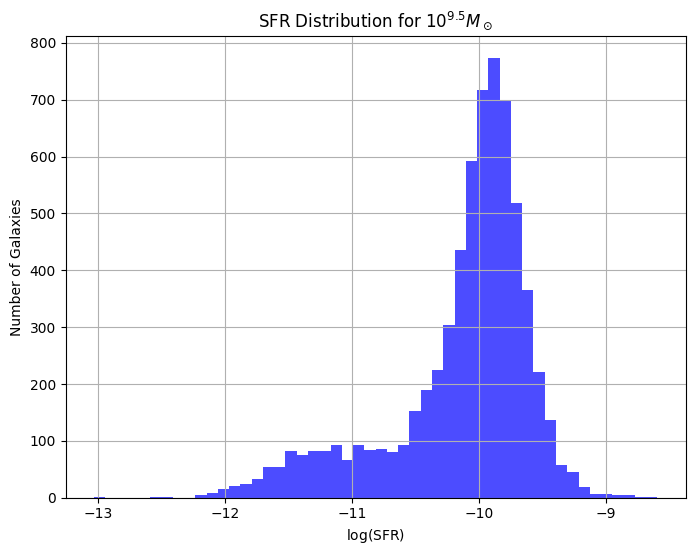

In [22]:
x = 9.5
epsilon = 0.1
my_slice = non_agn[(non_agn['lgm_tot_p50'] > x - epsilon) & (non_agn['lgm_tot_p50'] < x + epsilon)]

# Histogram of the SFR for galaxies with stellar mass around 10^9.5 solar masses.
plt.figure(figsize=(8, 6))
plt.hist(my_slice['specsfr_tot_p50'], bins=50, color='blue', alpha=0.7)
plt.xlabel(r'$\log(\mathrm{SFR})$')
plt.ylabel('Number of Galaxies')
plt.title('SFR Distribution for $10^{9.5} M_\odot$')
plt.grid(True)
plt.show()



/var/folders/2l/5qdg19zx40sdthfzpld2xpq80000gn/T/ipykernel_53348/3690724421.py:16: UserWarning: Mismatched number of handles and labels: len(handles) = 1 len(labels) = 5
  plt.legend(handles=handles[1:], labels=[f'Component {i}' for i in range(5)], title='GMM Components', markerscale=15)


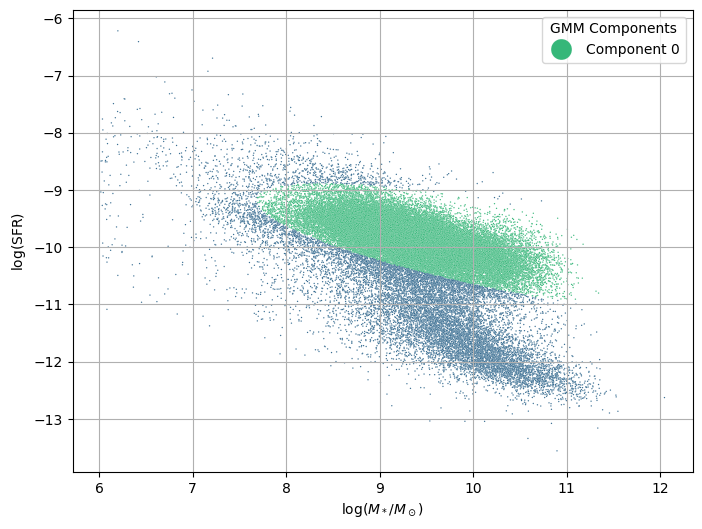

In [15]:
# Separating points in th ('sfr_tot_p50','lgm_tot_p50') plane using Gaussian Mixture Model
from sklearn.mixture import GaussianMixture


gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(non_agn[['lgm_tot_p50', 'specsfr_tot_p50']])
non_agn['gmm'] = gmm.predict(non_agn[['lgm_tot_p50', 'specsfr_tot_p50']])

plt.figure(figsize=(8, 6))
sns.scatterplot(x='lgm_tot_p50', y='specsfr_tot_p50', hue='gmm', data=non_agn, palette='viridis', s=1)
plt.xlabel(r'$\log(M_*/M_\odot)$')
plt.ylabel(r'$\log(\mathrm{SFR})$')
plt.grid(True)
# add handles for the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=[f'Component {i}' for i in range(5)], title='GMM Components', markerscale=15)
plt.show()

In [25]:
# Find the local minimum between 2 local maximums in the histogram.
hist, bin_edges = np.histogram(my_slice['specsfr_tot_p50'], bins=50)
diff = np.diff(hist)
# smooth the difference array
diff = np.convolve(diff, np.ones(3), mode='same')
# find the first local minimum
min_idx = np.where((diff[:-1] > 0) & (diff[1:] < 0))[0][0]
min_sfr = (bin_edges[min_idx] + bin_edges[min_idx + 1]) / 2

print("Local minimum in SFR:", min_sfr)

Local minimum in SFR: -11.3038559


In [24]:
diff

array([  -1,    0,    0,    0,    1,    1,   -2,    0,    4,    5,    6,
          6,    4,    8,   21,    0,   28,   -7,    7,    1,    9,  -26,
         27,   -9,    2,   -6,   13,   59,   38,   35,   78,  132,  157,
        125,   57,  -75, -180, -154, -143,  -86,  -79,  -12,  -26,  -13,
          0,   -2,    0,   -2,    0])

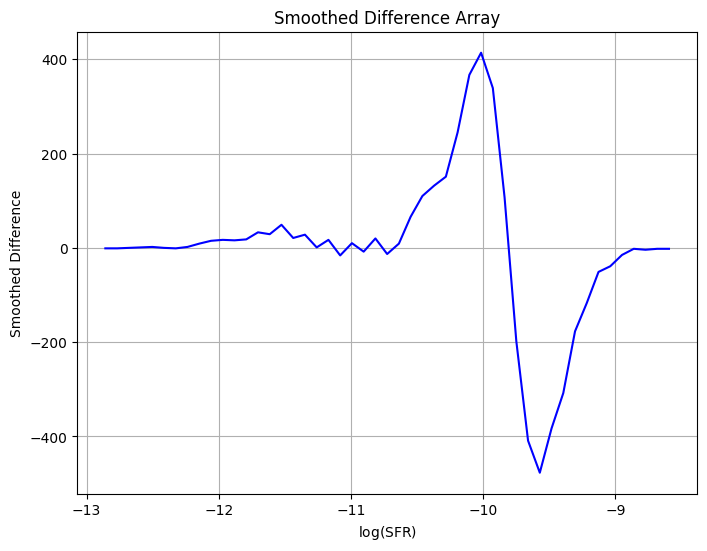

In [27]:
# Plot the smoothed difference array.
plt.figure(figsize=(8, 6))  
plt.plot(bin_edges[2:], diff, color='blue')
plt.xlabel(r'$\log(\mathrm{SFR})$')
plt.ylabel('Smoothed Difference')
plt.title('Smoothed Difference Array')
plt.grid(True)
plt.show()


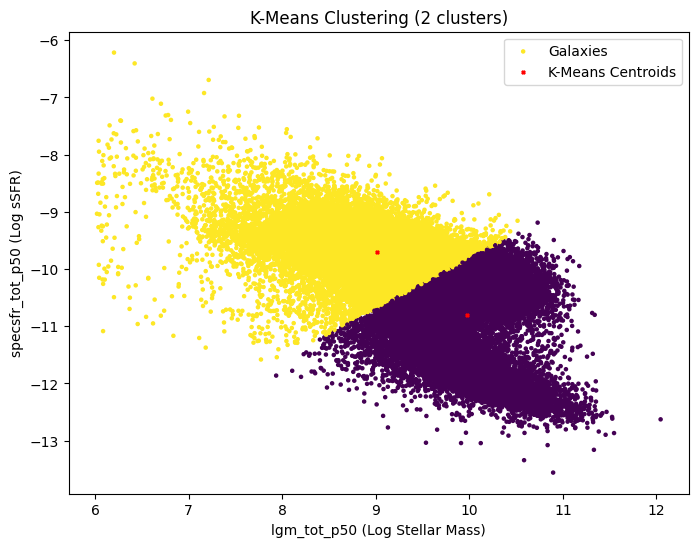

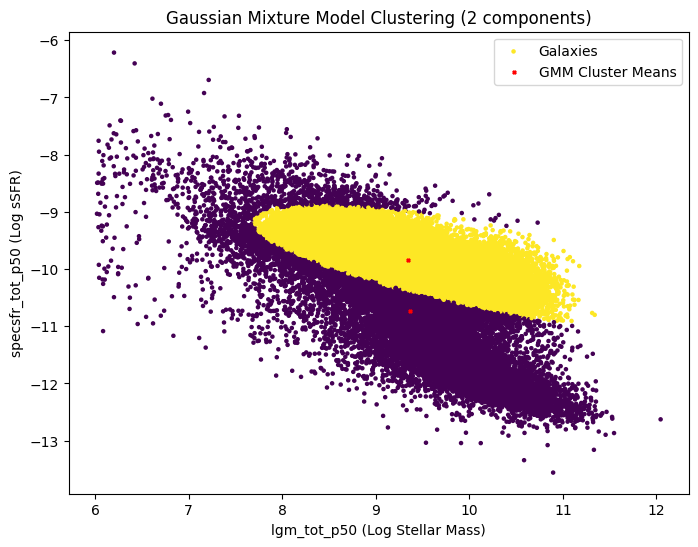

In [18]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Assuming `non_agn` is a DataFrame containing the columns 'lgm_tot_p50' and 'specsfr_tot_p50'
X = non_agn[['lgm_tot_p50', 'specsfr_tot_p50']].values

# 1. K-Means clustering (with 2 clusters)
kmeans = KMeans(n_clusters=2, random_state=0)
labels_kmeans = kmeans.fit_predict(X)

# 2. Gaussian Mixture Model clustering (with 2 components)
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
labels_gmm = gmm.fit_predict(X)

# Optional: Identify cluster centers for K-Means and GMM (for plotting markers)
centroids = kmeans.cluster_centers_
gmm_means = gmm.means_

# 3. Visualization of clusters
plt.figure(figsize=(8, 6))
# Scatter plot for K-Means clusters
plt.scatter(X[:, 0], X[:, 1], c=labels_kmeans, cmap='viridis', s=5, label='Galaxies')
# Mark centroids for K-Means
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=5, label='K-Means Centroids')
plt.xlabel('lgm_tot_p50 (Log Stellar Mass)')
plt.ylabel('specsfr_tot_p50 (Log sSFR)')
plt.title('K-Means Clustering (2 clusters)')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
# Scatter plot for GMM clusters
plt.scatter(X[:, 0], X[:, 1], c=labels_gmm, cmap='viridis', s=5, label='Galaxies')
# Mark Gaussian means for GMM
plt.scatter(gmm_means[:, 0], gmm_means[:, 1], c='red', marker='X', s=5, label='GMM Cluster Means')
plt.xlabel('lgm_tot_p50 (Log Stellar Mass)')
plt.ylabel('specsfr_tot_p50 (Log sSFR)')
plt.title('Gaussian Mixture Model Clustering (2 components)')
plt.legend()
plt.show()

<Axes: xlabel='lgm_tot_p50', ylabel='specsfr_tot_p50'>

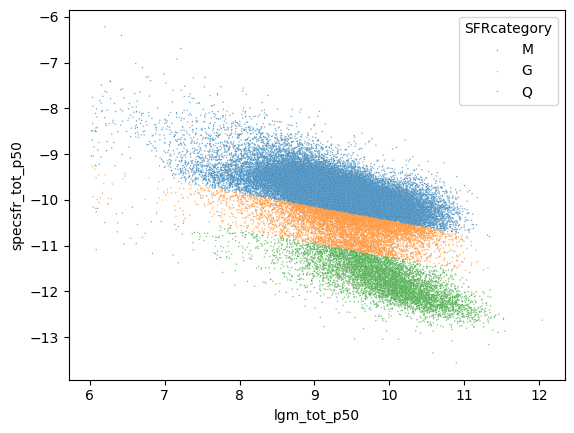

In [14]:
sns.scatterplot(data=non_agn, x='lgm_tot_p50', y='specsfr_tot_p50', hue='SFRcategory', alpha=0.7, s=1)

<Axes: xlabel='lgm_tot_p50', ylabel='specsfr_tot_p50'>

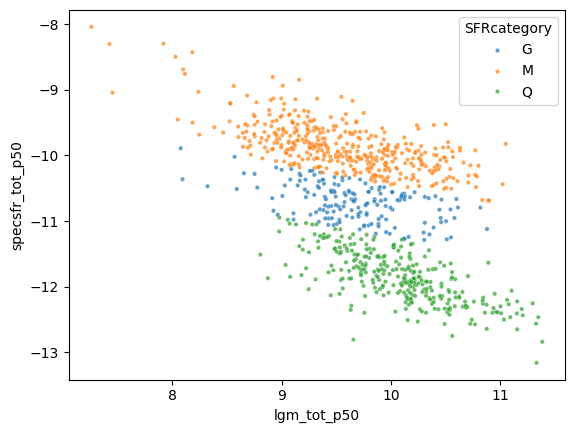

In [16]:
sns.scatterplot(data=HMCG_sfr, x='lgm_tot_p50', y='specsfr_tot_p50', hue='SFRcategory', alpha=0.7, s=10)

/var/folders/2l/5qdg19zx40sdthfzpld2xpq80000gn/T/ipykernel_25189/1595660028.py:3: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=df['log_NII_Ha'], y=df['log_OIII_Hb'], cmap='Blues', fill=True, shade_lowest=False)


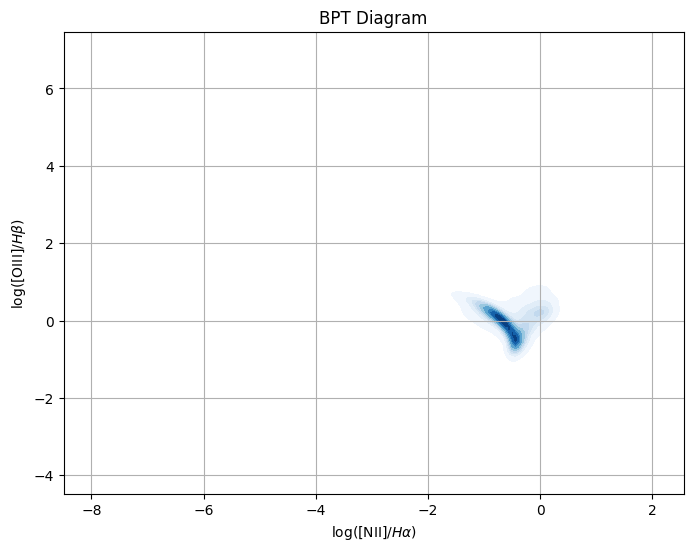

In [11]:
# density plot for df['log_NII_Ha'], df['log_OIII_Hb']
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df['log_NII_Ha'], y=df['log_OIII_Hb'], cmap='Blues', fill=True, shade_lowest=False)
plt.xlabel(r'$\log([\mathrm{NII}]/H\alpha)$')
plt.ylabel(r'$\log([\mathrm{OIII}]/H\beta)$')
plt.title('BPT Diagram')
plt.grid(True)
plt.show()

/var/folders/2l/5qdg19zx40sdthfzpld2xpq80000gn/T/ipykernel_1960/572912468.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['gmm'] = gmm.predict(df_clean[['log_NII_Ha', 'log_OIII_Hb']])
/var/folders/2l/5qdg19zx40sdthfzpld2xpq80000gn/T/ipykernel_1960/572912468.py:21: UserWarning: Mismatched number of handles and labels: len(handles) = 4 len(labels) = 5
  plt.legend(handles=handles[1:], labels=[f'Component {i}' for i in range(5)], title='GMM Components', markerscale=15)


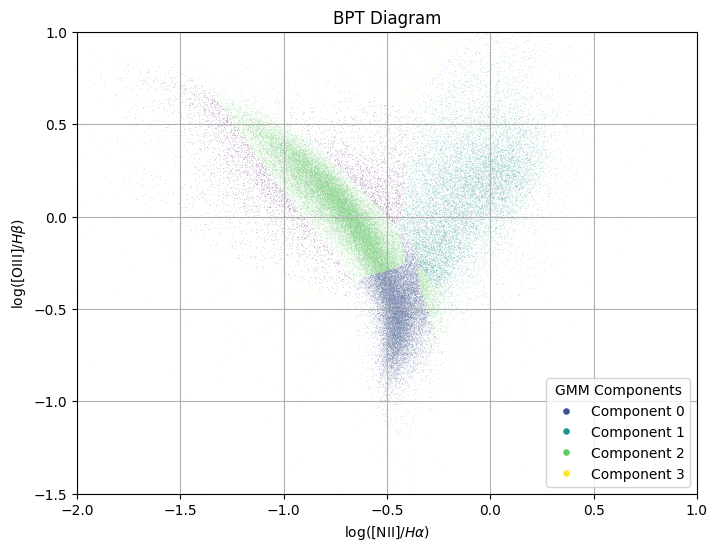

In [51]:
# import scikitplot as skplt
# from scipy.interpolate import interp1d
from sklearn.mixture import GaussianMixture

# Drop rows with NaN values in 'log_NII_Ha' and 'log_OIII_Hb'
df_clean = df.dropna(subset=['log_NII_Ha', 'log_OIII_Hb'])

# Gaussian mixture model for df_clean['log_NII_Ha'], df_clean['log_OIII_Hb']
gmm = GaussianMixture(n_components=5, random_state=0)
gmm.fit(df_clean[['log_NII_Ha', 'log_OIII_Hb']])
df_clean['gmm'] = gmm.predict(df_clean[['log_NII_Ha', 'log_OIII_Hb']])

plt.figure(figsize=(8, 6))
sns.scatterplot(x='log_NII_Ha', y='log_OIII_Hb', hue='gmm', data=df_clean, palette='viridis', s=0.1)
plt.xlabel(r'$\log([\mathrm{NII}]/H\alpha)$')
plt.ylabel(r'$\log([\mathrm{OIII}]/H\beta)$')
plt.title('BPT Diagram')
plt.grid(True)
# add handles for the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=[f'Component {i}' for i in range(5)], title='GMM Components', markerscale=15)
plt.xlim(-2, 1)
plt.ylim(-1.5, 1)
plt.show()

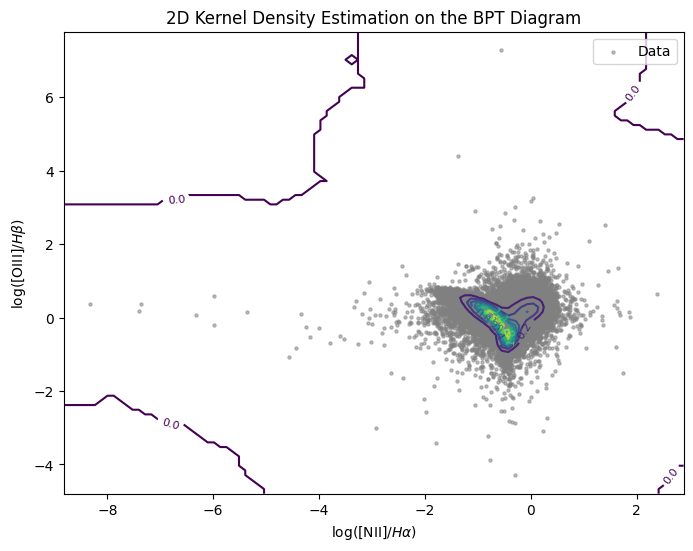

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Drop rows with NaN in the relevant columns
df_bpt = df.dropna(subset=['log_NII_Ha', 'log_OIII_Hb'])

# Extract the two columns into a NumPy array
X = df_bpt[['log_NII_Ha', 'log_OIII_Hb']].values

# Initialize and fit KernelDensity
kde = KernelDensity(bandwidth=0.07, kernel='gaussian')
kde.fit(X)

# Create a grid over the range of the data
x_vals = np.linspace(X[:,0].min() - 0.5, X[:,0].max() + 0.5, 100)
y_vals = np.linspace(X[:,1].min() - 0.5, X[:,1].max() + 0.5, 100)
xx, yy = np.meshgrid(x_vals, y_vals)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

# Evaluate the log density on the grid
log_density = kde.score_samples(grid_points)
density = np.exp(log_density)  # convert log density to linear scale

# Reshape for contour plotting
dens_2d = density.reshape(xx.shape)

plt.figure(figsize=(8, 6))

# Scatter plot of the original data
plt.scatter(X[:,0], X[:,1], s=5, color='gray', alpha=0.5, label='Data')

# Contour plot of the density
contour_levels = 10  # number of contour levels (tune as needed)
cs = plt.contour(xx, yy, dens_2d, levels=contour_levels, cmap='viridis')
plt.clabel(cs, inline=1, fontsize=8)

plt.xlabel(r'$\log([\mathrm{NII}]/H\alpha)$')
plt.ylabel(r'$\log([\mathrm{OIII}]/H\beta)$')
plt.title("2D Kernel Density Estimation on the BPT Diagram")
plt.legend()
plt.show()

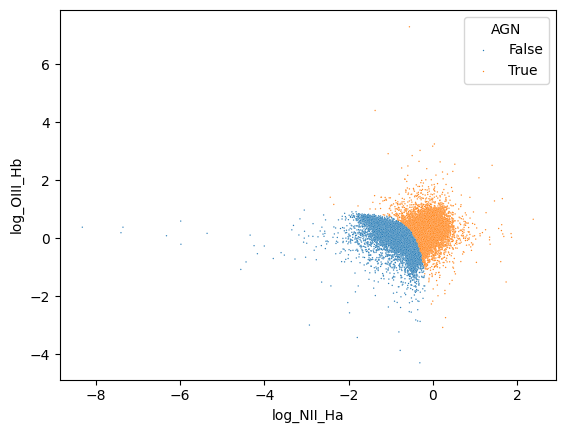

In [ ]:
# plot l_NII_over_Ha vs l_OIII_over_Hb, distinguishing AGN from non-AGN, small point size 
sns.scatterplot(data=df, x='log_NII_Ha', y='log_OIII_Hb', hue='is_AGN', s=1)
plt.legend(title='AGN')